In [1]:
""" 
cleaned version of the covid visualization notebook.
"""

' \ncleaned version of the covid visualization notebook.\n'

In [2]:
"""
input choices and load plots.

state_abb: state abbreviation
data_type: "cumm_death", "incd_death", "cumm_case", "incd_case"   
horizon: "1w" or "4w"
"""

state_abb = "US"
data_type = "incd_case"
horizon_type = "1w"

#best model (or individual model to study)
    #best persistent inc_case 1w & 4w: COVIDhub-baseline
    #best persistent inc_death 1w: UMass-MechBayes
    #best persistent inc_death 4w: MOBS-GLEAM_COVID
best_mod = "COVIDhub-baseline"

In [3]:
# Ensure notebook is being run from base repository directory
COVID_HOME = "/Users/efua/documents/uni/spring-2021/UROP/covid19-forecast-hub"
import os, sys
try:
    os.chdir(COVID_HOME)
except Exception as err:
    print(f"Warning: unable to change directory; {repr(err)}")
from src.utils.notebook_util import isnotebook
if isnotebook():
    # Autoreload packages that are modified
    %load_ext autoreload
    %autoreload 2
else:
    from argparse import ArgumentParser
    
# Computational libraries 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy.matlib
from collections import deque

# os libraries 
import shutil
from datetime import datetime, timedelta
from functools import partial
import copy
import pdb
import os

from utils import *
from file_util import *
from attributes import *

from zoo_of_experts import *
from zoo_of_hinters import *
from zoo_of_losses import *

import matplotlib.pyplot as plt

#print all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#abbreviation to fips, hard code ver.
def FIPSconvert(entry):
    FIPSdict = {
        "US": "US", "AL": 1, "AK": 2, "AZ": 4, "AR": 5, "CA": 6, "CO": 8, "CT": 9, "DE": 10, "DC": 11,
        "FL": 12, "GA": 13, "HI": 15, "ID": 16, "IL": 17, "IN": 18, "IA": 19, "KS": 20, "KY": 21, "LA": 22,
        "ME": 23, "MD": 24, "MA": 25, "MI": 26, "MN": 27, "MS": 28, "MO": 29, "MT": 30, "NE": 31, "NV": 32,
        "NH": 33, "NJ": 34, "NM": 35, "NY": 36, "NC": 37, "ND": 38, "OH": 39, "OK": 40, "OR": 41, "PA": 42, 
        "RI": 44, "SC": 45, "SD": 46, "TN": 47, "TX": 48, "UT": 49, "VT": 50, "VA": 51, "WA": 53, "WV": 54,
        "WI": 55, "WY": 56, "AS": 60, "GU": 66, "MP": 69, "PR": 72, "UM": 74, "VI": 78,
    }
    
    if entry in FIPSdict:
        locCode = FIPSdict.get(entry)
        return(locCode)

In [5]:
"""
load data and read in ground truth and model predictions for tasks.
"""


"""
set model parameters.
"""
#convert state to FIPS code
state_abb = str(FIPSconvert(state_abb))

# Specify model parameters
model_name = "online_expert" 

if not isnotebook():
    # If notebook run as a script, parse command-line arguments
    parser = ArgumentParser()
    parser.add_argument("pos_vars",nargs="*")  # gt_id and horizon 
    parser.add_argument('--target_dates', '-t', default="std_future")
    args, opt = parser.parse_known_args()

    # Assign variables                                                                                                                                     
    gt_id = get_id_name(args.pos_vars[0]) # "contest_precip" or "contest_tmp2m"                                                                            
    horizon = get_th_name(args.pos_vars[1]) # "34w" or "56w"    
    target_date_str = args.target_dates # target date object
else:
    # Otherwise, specify arguments interactively
    gt_id = data_type  #"contest_precip", "contest_tmp2m". choices: "cumm_death", "incd_death", "cumm_case", "incd_case"     
    target_date_str = "std_weekly" #"contest_precip", "contest_tmp2m"
    location = state_abb
    quantile = 0.5
    horizon = horizon_type

"""
Read in ground truth and model predictions for task
"""
# Get location FIPS codes
fips_codes = get_fips_codes() 

# Read ground truth 
printf(f'Loading {gt_id} ground truth')
df_gt = get_ground_truth(gt_id, location, load_df=True)

# Get target dates
first_date, last_date = get_data_range(gt_id, location=location)
printf(f"Getting target dates from {first_date} to {last_date}.")
target_dates = get_target_dates(target_date_str, first_date, last_date)
target_date_objs = pd.Series(target_dates)

# Store delta between target date and forecast issuance date
start_delta = timedelta(days=get_start_delta(horizon, gt_id))

# Get model predicitons for the task
printf(f'Loading model predictions for {gt_id}, {horizon}, {location}, q{quantile}')
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)

# Get model list
persistant_models, all_models = get_persistant_models(model_pred_df)
expert_models = list(all_models)
expert_models.sort()
model_string = (',').join(expert_models)
printf(f"Predictions for models loaded:\n {expert_models}")

'\nload data and read in ground truth and model predictions for tasks.\n'

'\nset model parameters.\n'

'\nRead in ground truth and model predictions for task\n'

Loading incd_case ground truth
Getting target dates from 2020-01-29 00:00:00 to 2021-05-10 00:00:00.
Loading model predictions for incd_case, 1w, US, q0.5
Predictions for models loaded:
 ['BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline', 'COVIDhub-ensemble', 'COVIDhub-trained_ensemble', 'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator', 'CovidAnalytics-DELPHI', 'DDS-NBDS', 'FDANIHASU-Sweight', 'IEM_MED-CovidProject', 'IHME-CurveFit', 'IQVIA_ACOE-STAN', 'IUPUI-HkPrMobiDyR', 'IowaStateLW-STEM', 'JCB-PRM', 'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID', 'Microsoft-DeepSTIA', 'OliverWyman-Navigator', 'OneQuietNight-ML', 'QJHong-Encounter', 'RobertWalraven-ESG', 'SigSci-TS', 'UCF-AEM', 'UCLA-SuEIR', 'UChicagoCHATTOPADHYAY-UnIT', 'UMich-RidgeTfReg', 'USACE-ERDC_SEIR', 'USC-SI_kJalpha', 'USC-SI_kJalpha_RF', 'UVA-En

In [6]:
""" 
load groundtruth & ensemble dataframes and create series.
"""

""" dataframes """
#groundtruth df
GT_copy = df_gt 
GT_data = GT_copy.reset_index()
GT_dates = []
for index, row in GT_data.iterrows(): #convert from timestamp to regular dates.
    date = row["date"].date()
    datestr = date.strftime("%Y-%m-%d")
    GT_dates.append(datestr)
GT_vals = GT_data['gt']
GT_timestamps = GT_data['date']

#median ensemble df
median_ens = model_pred_df.groupby(['target_end_date']).median() 
MEDENS_copy = median_ens
MEDENS_data = MEDENS_copy.reset_index()
MEDENS_dates = MEDENS_data['target_end_date']
MEDENS_vals = MEDENS_data['value']

#mean ensemble df
mean_ens = model_pred_df.groupby(['target_end_date']).mean() 
MEAENS_copy = mean_ens
MEAENS_data = MEAENS_copy.reset_index()
MEAENS_dates = MEAENS_data['target_end_date']
MEAENS_vals = MEAENS_data['value']

""" series """
#make groundtruth series
GT_dict = {}
for index, row in GT_data.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    GT_dict[datestr] = row["gt"]
GT_series = pd.Series(data=GT_dict, index=MEDENS_dates) #matching gt values to ensemble dates.
#make median ensemble series
MEDENS_dict = {}
for index, row in MEDENS_data.iterrows():
    MEDENS_dict[row["target_end_date"]] = row["value"]
MEDENS_series = pd.Series(data=MEDENS_dict, index=MEDENS_dates)

#make mean ensemble series
MEAENS_dict = {}
for index, row in MEAENS_data.iterrows():
    MEAENS_dict[row["target_end_date"]] = row["value"]
MEAENS_series = pd.Series(data=MEAENS_dict, index=MEAENS_dates)


' \nload groundtruth & ensemble dataframes and create series.\n'

' dataframes '

' series '

In [7]:
""" 
loss and regret calculations.
"""
#calculating average error in loss series.
def err_avg(loss_series):
    entries = 0
    tot = 0
    for x in loss_series:
        entries += 1
        tot += x
    e_avg = tot / entries
    return e_avg

#calculating regret in loss series.
def regretFind(ens_loss, model_loss):  
    return (ens_loss - model_loss)

#median and mean ensemble loss
MEDENS_loss = MAELoss.loss(0,GT_series,MEDENS_series) #median ensemble loss
MEAENS_loss = MAELoss.loss(0,GT_series,MEAENS_series) #mean ensemble loss

#cumulative error averages
MEDENS_loss_avg = err_avg(MEDENS_loss)
MEAENS_loss_avg = err_avg(MEAENS_loss)


' \nloss and regret calculations.\n'

In [8]:
""" 
get models with the most dates
"""
most_dates = []
total_mods = 0
for mod in expert_models:
        total_mods += 1
        #make model series
        mod_choice = str(mod)
        mod_tab = model_pred_df['value'][mod_choice]
        mod_tab = mod_tab.reset_index()
        fst_lst = mod_tab['target_end_date'].iloc[[0, -1]]
        first_date = fst_lst.iloc[0]
        last_date = fst_lst.iloc[1]
        #print(f"#{mod} date range: {first_date} to {last_date}")
        #RANGE FOR INC_CASES 1w: if (first_date <= "2020-07-11") and ("2021-02-27" <= last_date):
        #RANGE FOR INC_DEATH 1w: if (first_date <= "2020-05-30") and ("2021-02-27" <= last_date):
        if (first_date <= "2020-07-11") and ("2021-02-27" <= last_date):
            most_dates.append(mod)
            
inc_ct = len(most_dates)
exc_ct = total_mods - inc_ct
print(f"{total_mods} models for {data_type}. {inc_ct} included for date range, {exc_ct} excluded for missing dates.")


' \nget models with the most dates\n'

44 models for incd_case. 11 included for date range, 33 excluded for missing dates.


'\nPLOT 1: all ensembles and models vs groundtruth, data\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

([<matplotlib.axis.XTick at 0x7fa0b7b5bb90>,
 <a list of 24 Text major ticklabel objects>)

Text(0.5, 0, 'count')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Ensembles vs All Models (raw data): incd_case for US, 1w horizon.')

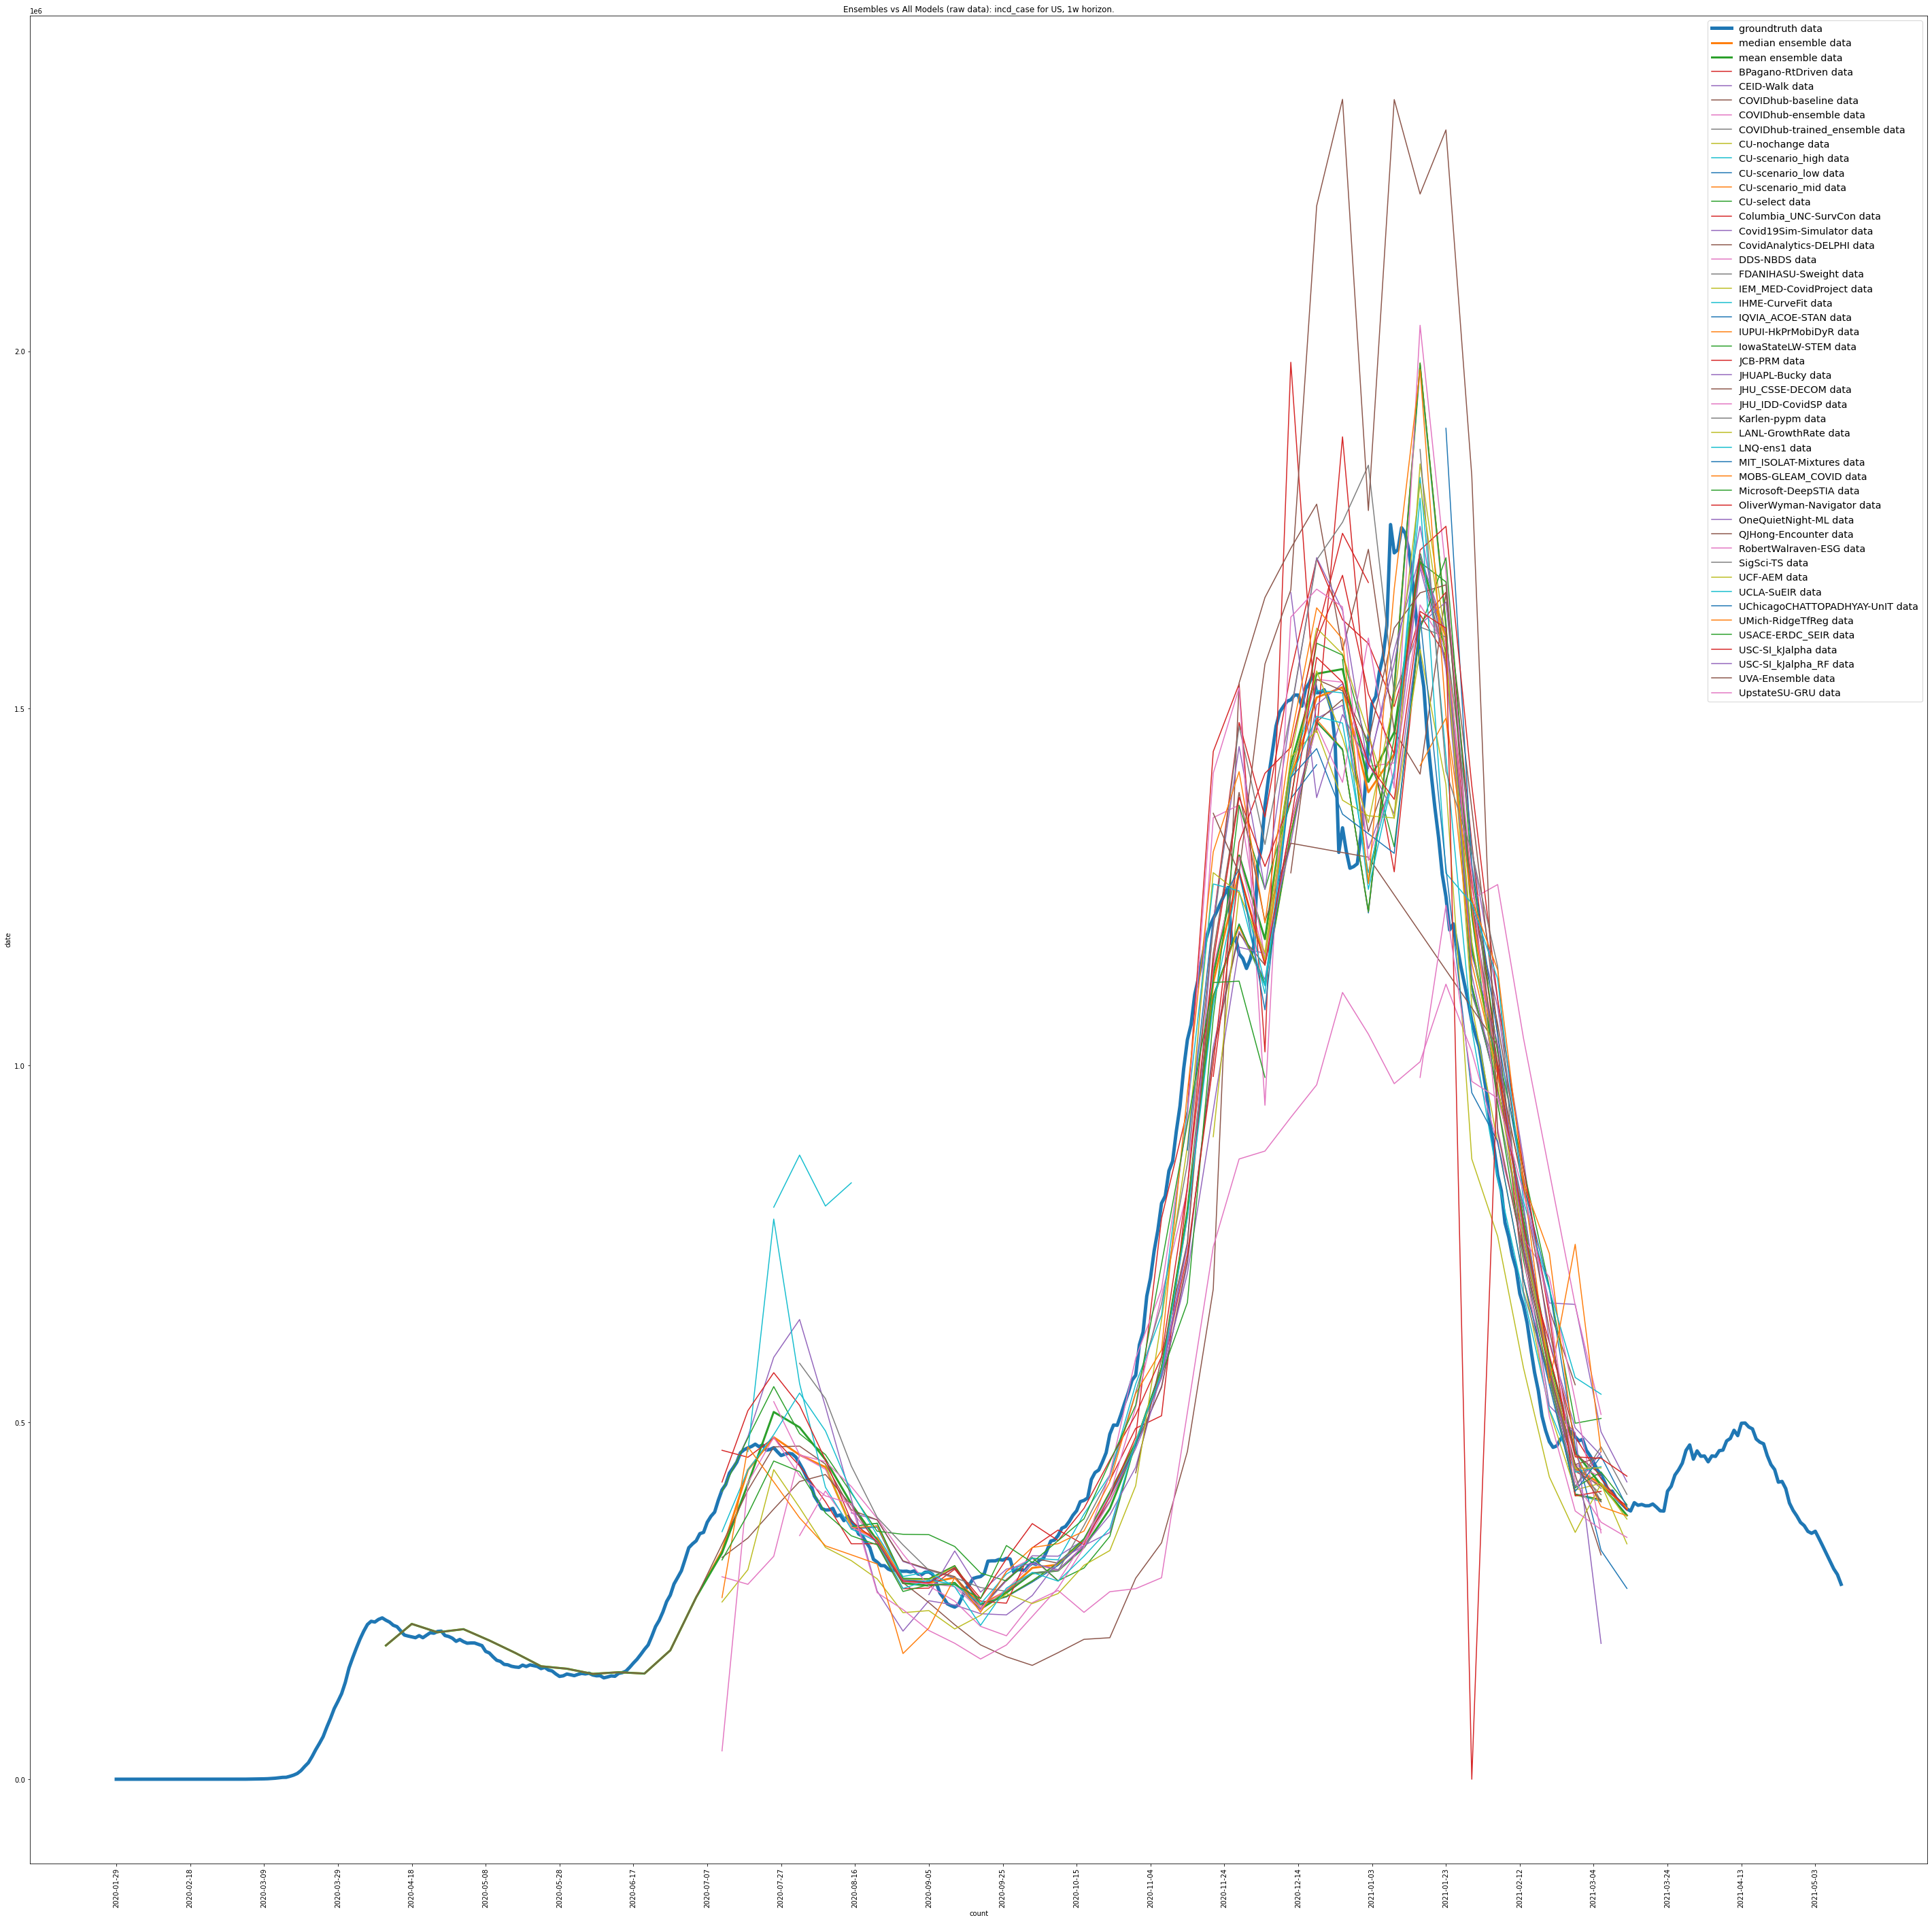

In [9]:
"""
PLOT 1: all ensembles and models vs groundtruth, data
"""
fig, ax = plt.subplots(figsize=(50,50))
ax.plot(GT_dates, GT_vals, label='groundtruth data', linewidth=5)
ax.plot(MEDENS_dates, MEDENS_vals, label='median ensemble data', linewidth=3)
ax.plot(MEAENS_dates, MEAENS_vals, label='mean ensemble data', linewidth=3)
for mod in expert_models:
        #make model plot
        model_choice = str(mod)
        IND_model = model_pred_df['value'][model_choice]
        IND_data = IND_model.reset_index()
        IND_dates = IND_data['target_end_date']
        IND_vals = IND_data['value']
        ax.plot(IND_dates, IND_vals, label=f'{model_choice} data')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(GT_dates), 20))
plt.xlabel('count')
plt.ylabel('date')
plt.title(f'Ensembles vs All Models (raw data): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()


'\nPLOT 2: all ensembles and models, MAE\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text major ticklabel objects>)

Text(0.5, 0, 'error')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Ensembles vs All Models (MAE): incd_case for US, 1w horizon.')

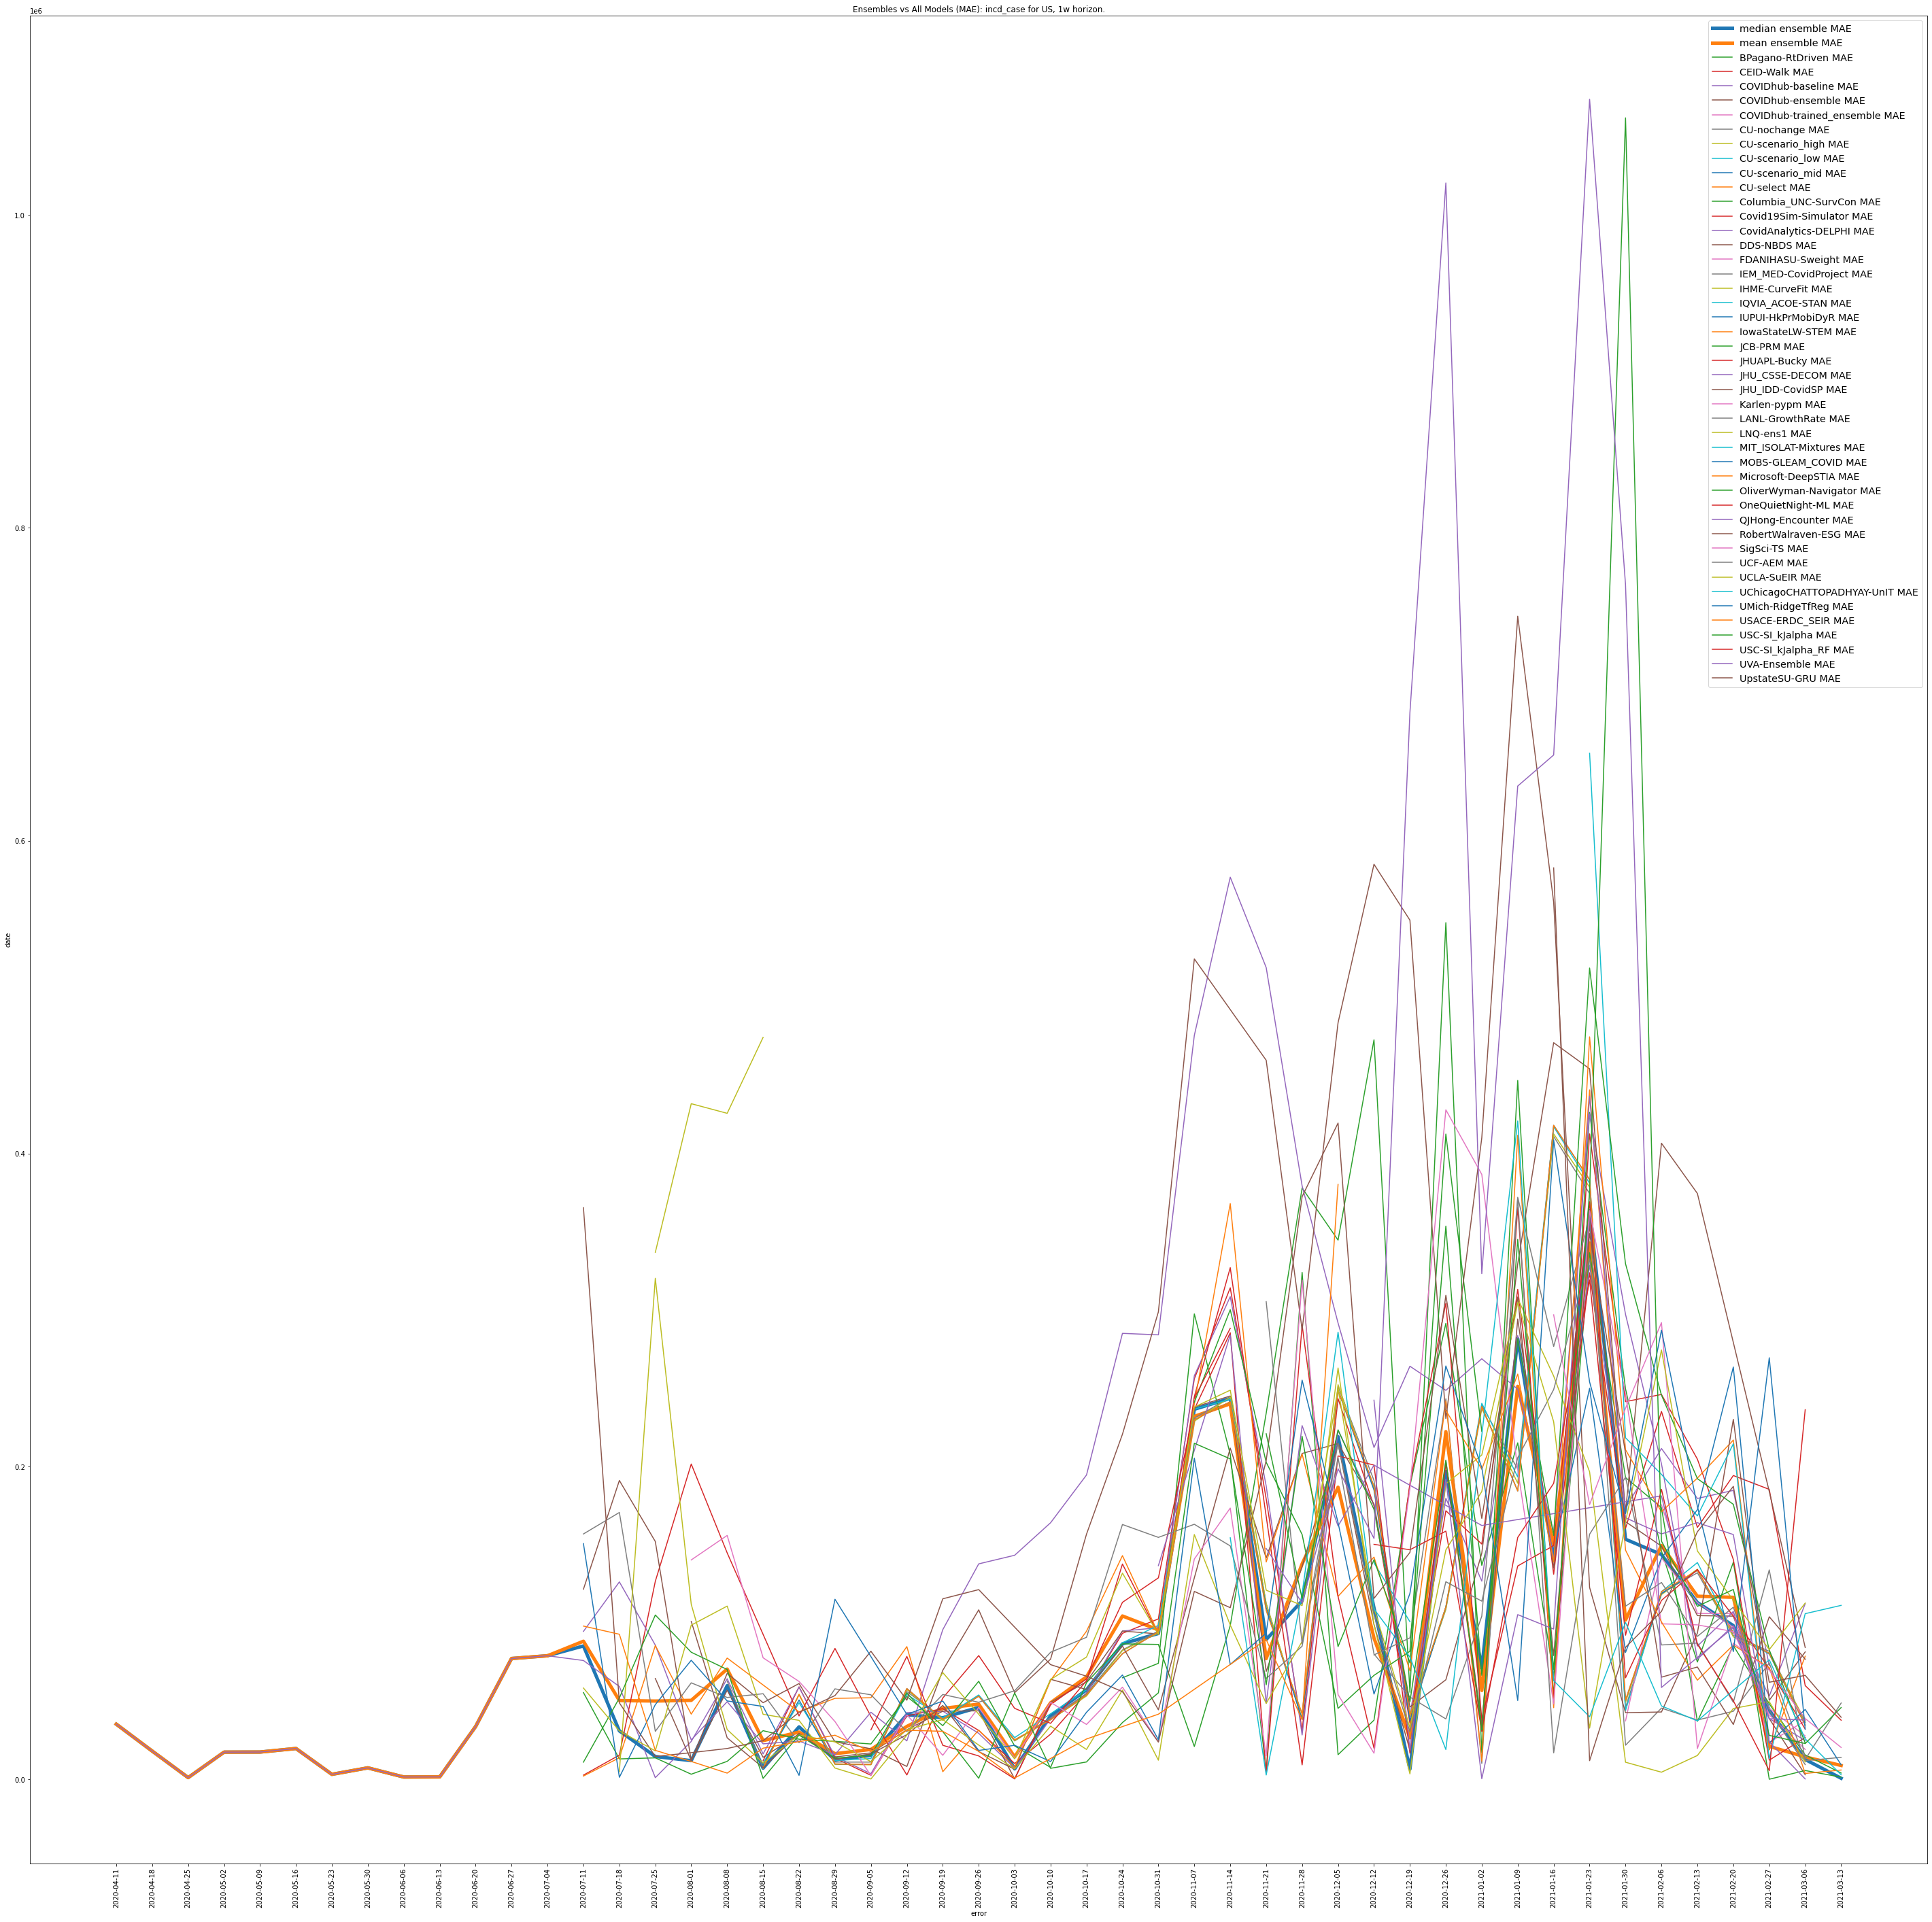

In [10]:
"""
PLOT 2: all ensembles and models, MAE
"""
fig, ax = plt.subplots(figsize=(50,50))
ax.plot(MEDENS_dates, MEDENS_loss.values, label='median ensemble MAE', linewidth=5)
ax.plot(MEAENS_dates, MEAENS_loss.values, label='mean ensemble MAE', linewidth=5)
for mod in expert_models:
        #make model series
        model_choice = str(mod)
        IND_model = model_pred_df['value'][model_choice]
        IND_data = IND_model.reset_index()
        IND_dates = IND_data['target_end_date'].tolist() 
        IND_dict = {}
        for index, row in IND_data.iterrows():
            IND_dict[row["target_end_date"]] = row["value"]
        IND_series = pd.Series(data=IND_dict, index=IND_dates)

        #make filtered groundtruth series
        GT_filter_dict = {}
        for index, row in GT_data.iterrows():
            dat = row["date"].date()
            datestr = dat.strftime("%Y-%m-%d")
            if datestr in IND_dates:
                GT_filter_dict[datestr] = row["gt"]
        GT_filter_series = pd.Series(data=GT_filter_dict, index=IND_dates)
        
        #calculate and plot model MAE
        IND_loss = MAELoss.loss(0,GT_filter_series,IND_series)
        ax.plot(IND_dates, IND_loss.values, label=f'{model_choice} MAE')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.xticks(rotation=90)
plt.xlabel('error')
plt.ylabel('date')
plt.title(f'Ensembles vs All Models (MAE): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()

'\nPLOT 3: median ensemble and models, regret\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text major ticklabel objects>)

Text(0.5, 0, 'error')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Median Ensemble vs All Models (Regret): incd_case for US, 1w horizon.')

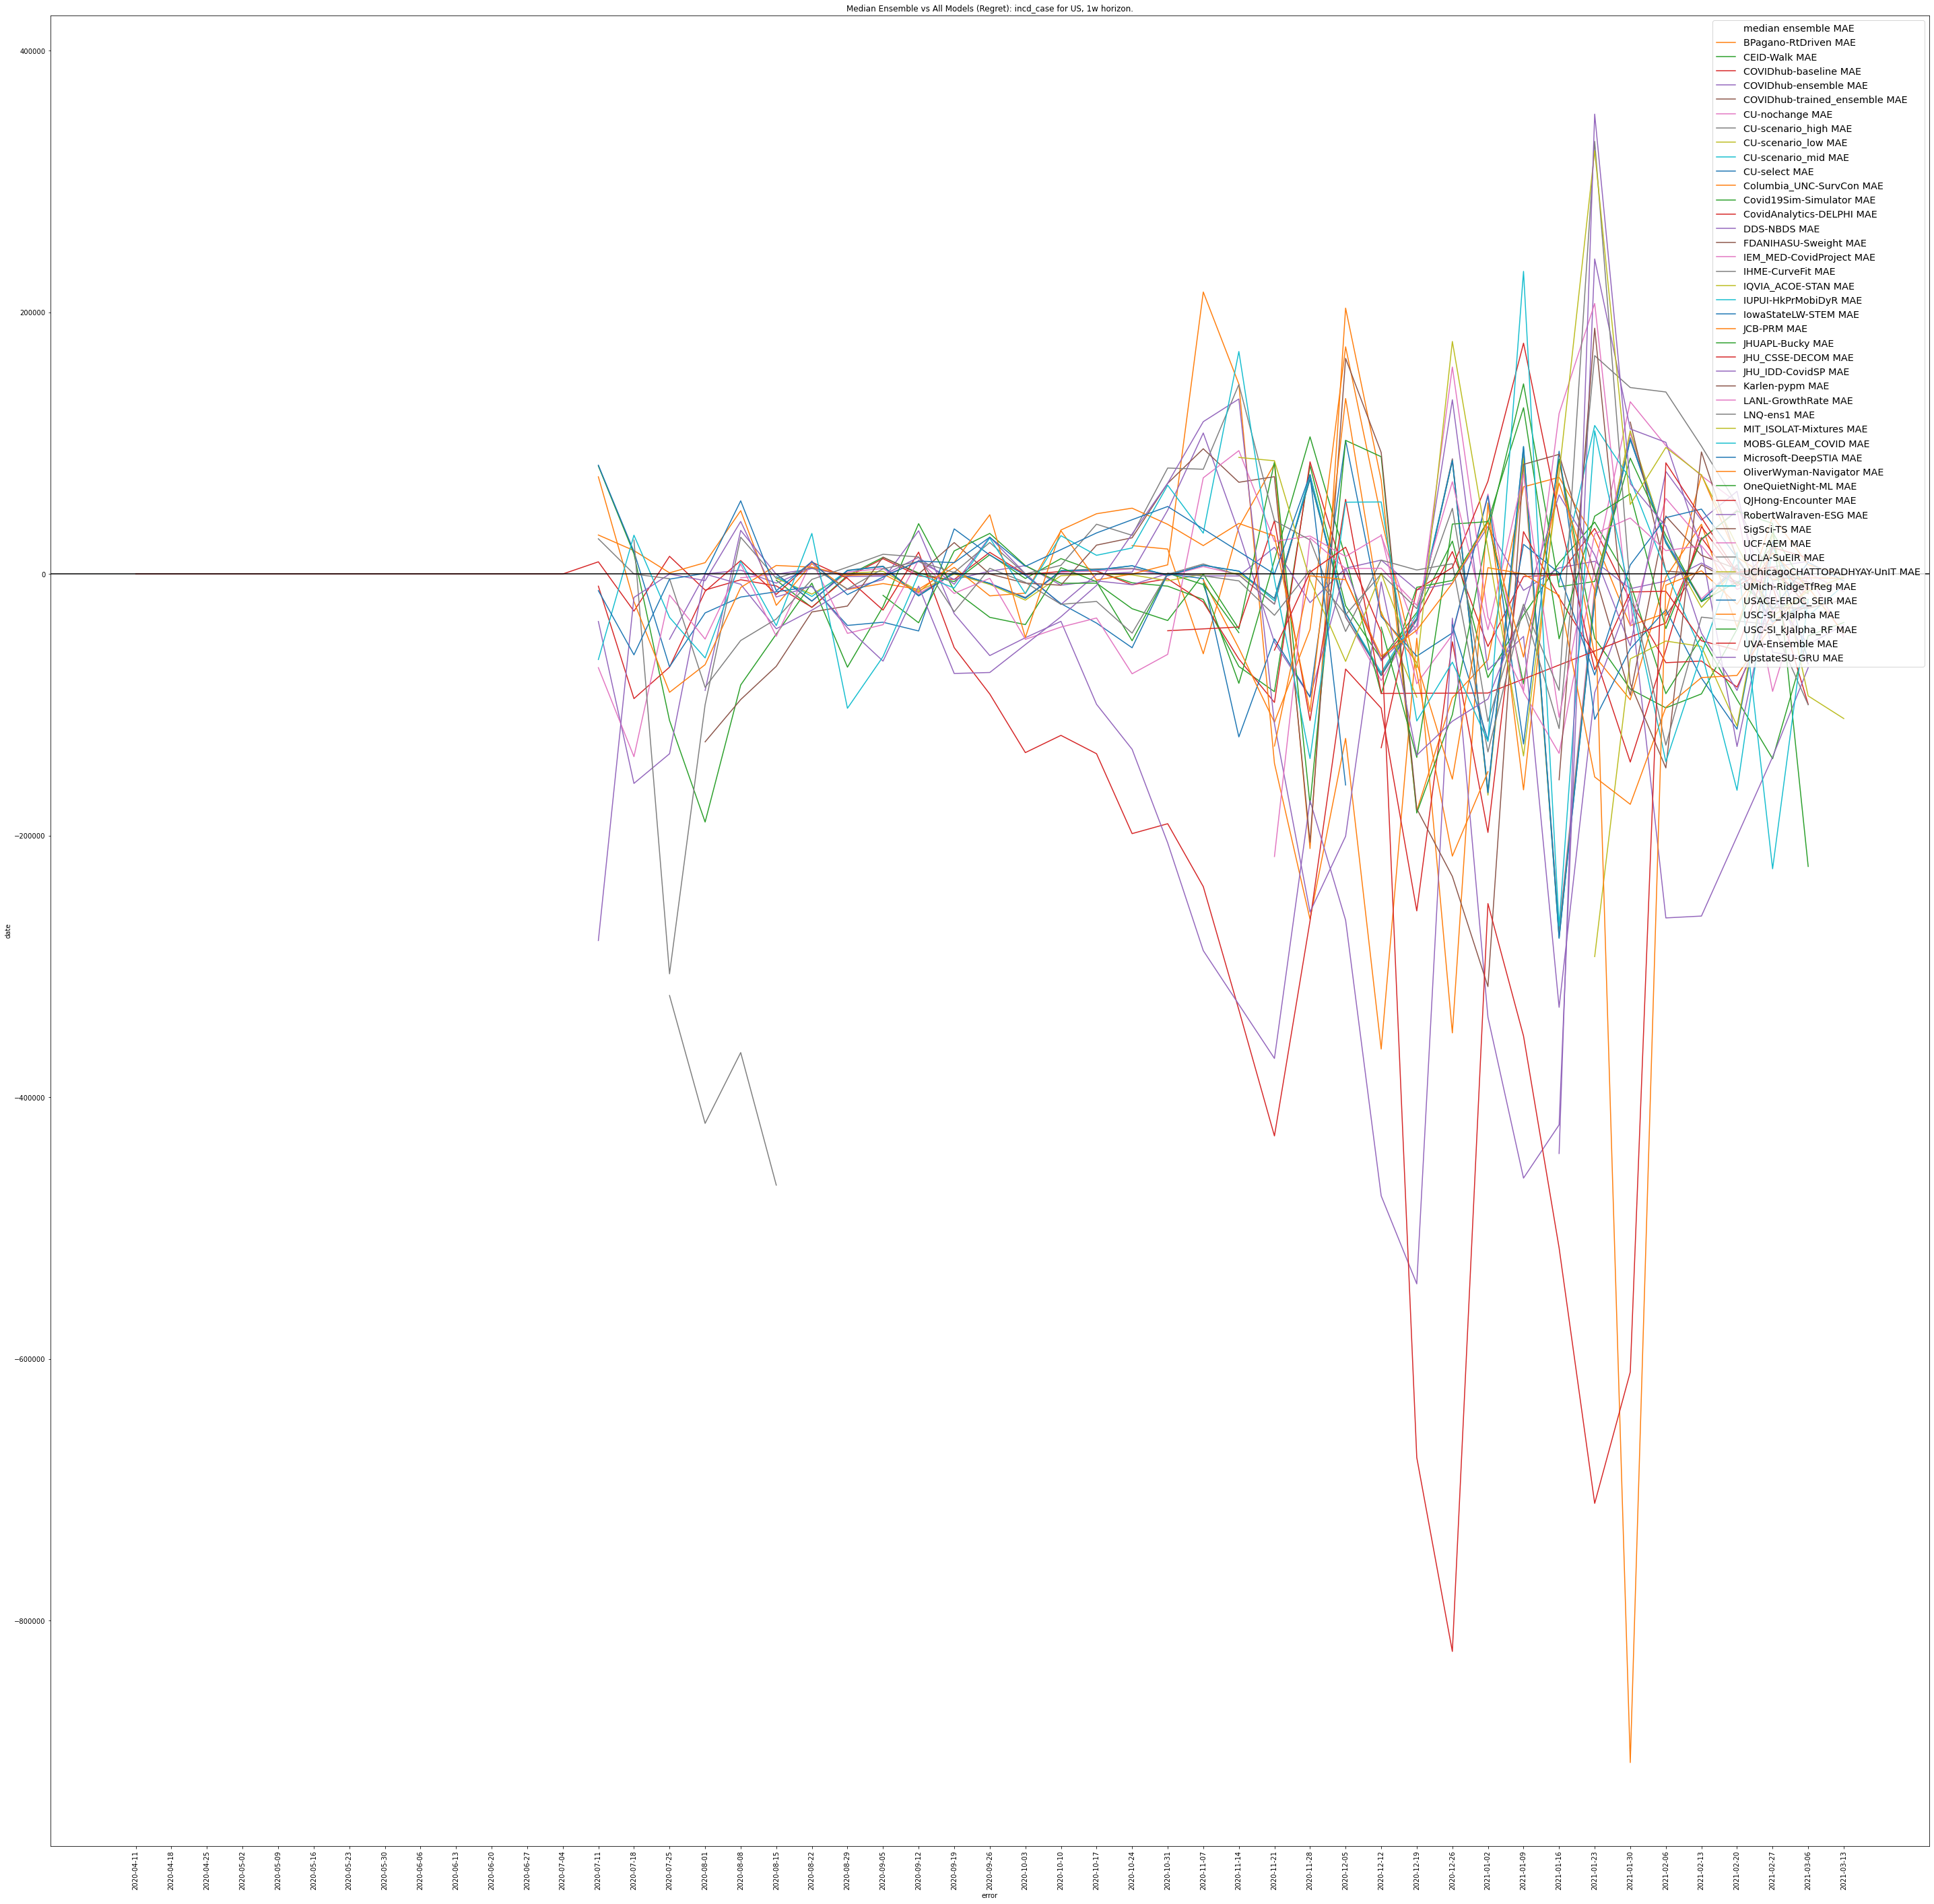

In [11]:
"""
PLOT 3: median ensemble and models, regret
"""
fig, ax = plt.subplots(figsize=(50,50))
ax.plot(MEDENS_dates, MEDENS_loss.values, label='median ensemble MAE', linewidth=0)
for mod in expert_models:
        #make model series
        model_choice = str(mod)
        IND_model = model_pred_df['value'][model_choice]
        IND_data = IND_model.reset_index()
        IND_dates = IND_data['target_end_date'].tolist() 
        IND_dict = {}
        for index, row in IND_data.iterrows():
            IND_dict[row["target_end_date"]] = row["value"]
        IND_series = pd.Series(data=IND_dict, index=IND_dates)
        
        #make filtered groundtruth series
        GT_filter_dict = {}
        for index, row in GT_data.iterrows():
            dat = row["date"].date()
            datestr = dat.strftime("%Y-%m-%d")
            if datestr in IND_dates:
                GT_filter_dict[datestr] = row["gt"]
        GT_filter_series = pd.Series(data=GT_filter_dict, index=IND_dates)

        #make filtered median ensemble series
        MED_filter_dict = {}
        for index, row in MEDENS_data.iterrows():
            dat = row["target_end_date"]
            if dat in IND_dates:
                MED_filter_dict[dat] = row["value"]
        MED_filter_series = pd.Series(data=MED_filter_dict, index=IND_dates)

        #calculate MAE
        IND_loss = MAELoss.loss(0,GT_filter_series,IND_series)
        MED_filter_loss = MAELoss.loss(0,GT_filter_series,MED_filter_series)
        
        #calculate regret
        IND_MED_regret = regretFind(MED_filter_loss, IND_loss)
        ax.plot(IND_dates, IND_MED_regret.values, label=f'{model_choice} MAE')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.axhline(y=0, color='black', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('error')
plt.ylabel('date')
plt.title(f'Median Ensemble vs All Models (Regret): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()


'\nPLOT 4: all ensembles and persistant models vs groundtruth, data\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

([<matplotlib.axis.XTick at 0x7fa0a75ba310>,
 <a list of 24 Text major ticklabel objects>)

Text(0.5, 0, 'count')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Ensembles vs Persistent Models (raw data): incd_case for US, 1w horizon.')

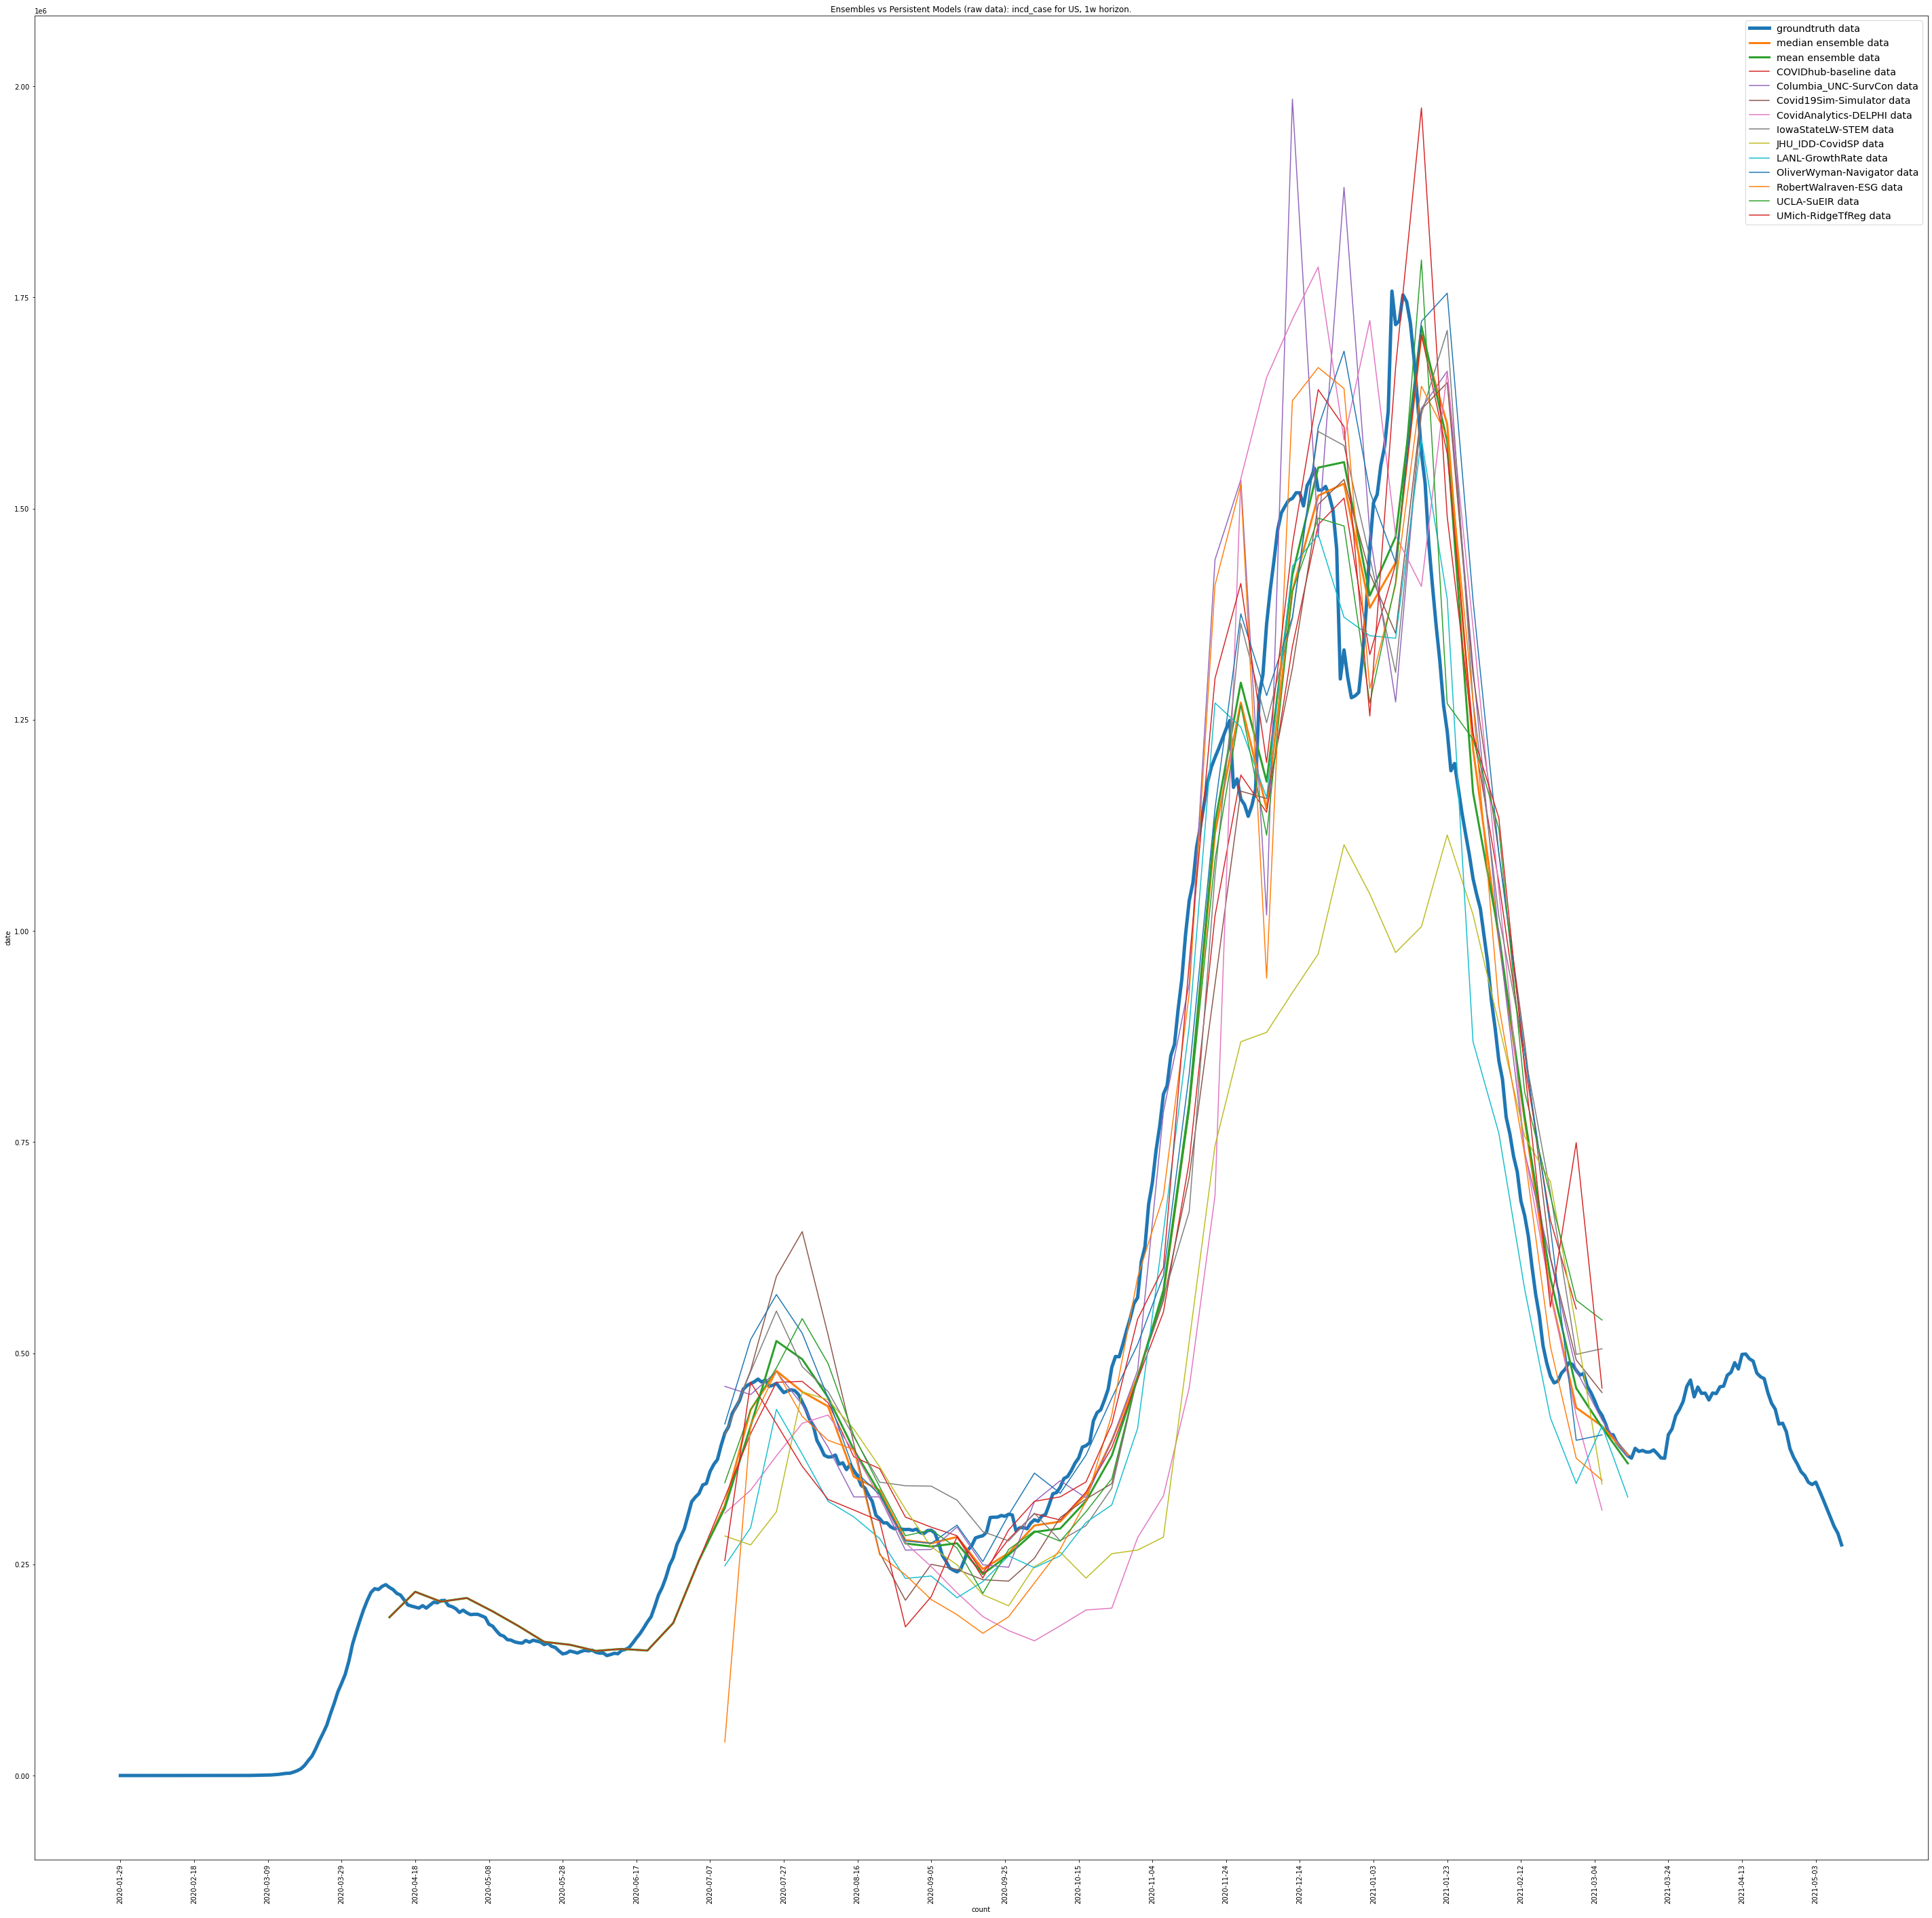

In [12]:
"""
PLOT 4: all ensembles and persistant models vs groundtruth, data
"""
fig, ax = plt.subplots(figsize=(50,50))
ax.plot(GT_dates, GT_vals, label='groundtruth data', linewidth=5)
ax.plot(MEDENS_dates, MEDENS_vals, label='median ensemble data', linewidth=3)
ax.plot(MEAENS_dates, MEAENS_vals, label='mean ensemble data', linewidth=3)
for mod in most_dates:
        #make model plot
        model_choice = str(mod)
        IND_model = model_pred_df['value'][model_choice]
        IND_data = IND_model.reset_index()
        IND_dates = IND_data['target_end_date']
        IND_vals = IND_data['value']
        ax.plot(IND_dates, IND_vals, label=f'{model_choice} data')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(GT_dates), 20))
plt.xlabel('count')
plt.ylabel('date')
plt.title(f'Ensembles vs Persistent Models (raw data): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()

'\nPLOT 5: all ensembles and persistant models, MAE\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text major ticklabel objects>)

Text(0.5, 0, 'error')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Ensembles vs Persistent Models (MAE): incd_case for US, 1w horizon.')

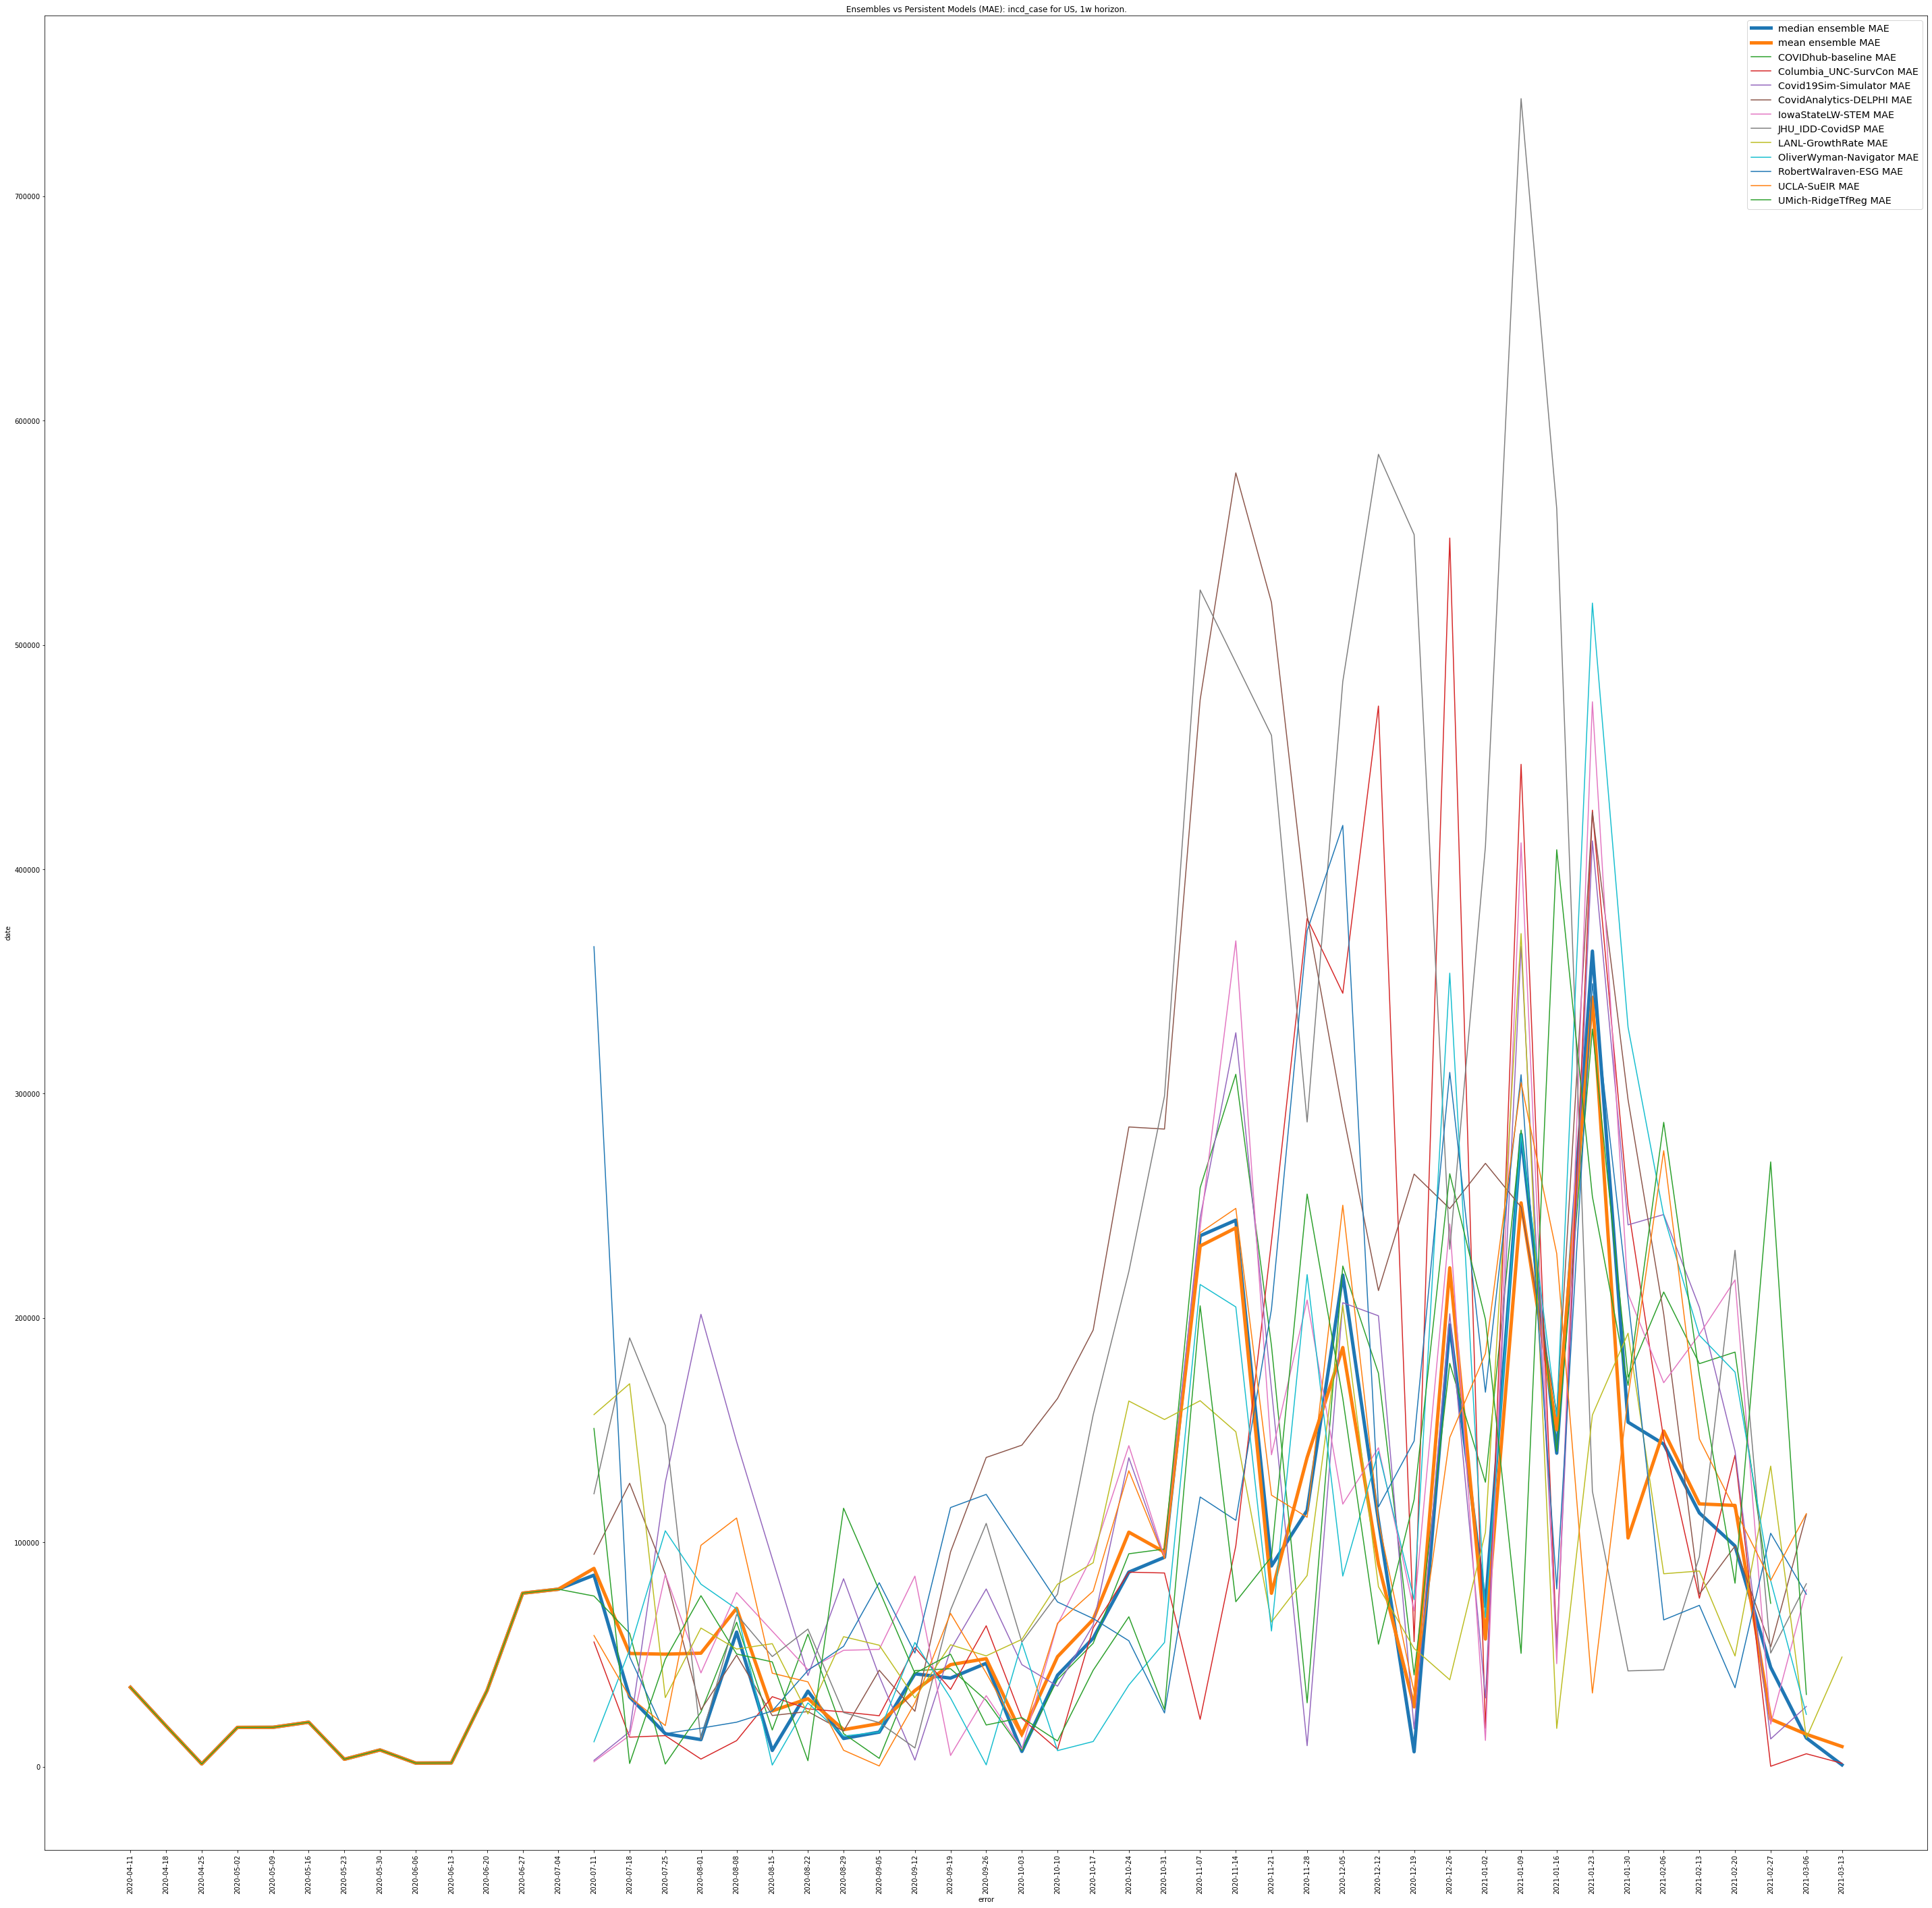

In [13]:
"""
PLOT 5: all ensembles and persistant models, MAE
"""
fig, ax = plt.subplots(figsize=(50,50))
ax.plot(MEDENS_dates, MEDENS_loss.values, label='median ensemble MAE', linewidth=5)
ax.plot(MEAENS_dates, MEAENS_loss.values, label='mean ensemble MAE', linewidth=5)
for mod in most_dates:
        #make model series
        model_choice = str(mod)
        IND_model = model_pred_df['value'][model_choice]
        IND_data = IND_model.reset_index()
        IND_dates = IND_data['target_end_date'].tolist() 
        IND_dict = {}
        for index, row in IND_data.iterrows():
            IND_dict[row["target_end_date"]] = row["value"]
        IND_series = pd.Series(data=IND_dict, index=IND_dates)

        #make filtered groundtruth series
        GT_filter_dict = {}
        for index, row in GT_data.iterrows():
            dat = row["date"].date()
            datestr = dat.strftime("%Y-%m-%d")
            if datestr in IND_dates:
                GT_filter_dict[datestr] = row["gt"]
        GT_filter_series = pd.Series(data=GT_filter_dict, index=IND_dates)
        
        #calculate and plot model MAE
        IND_loss = MAELoss.loss(0,GT_filter_series,IND_series)
        ax.plot(IND_dates, IND_loss.values, label=f'{model_choice} MAE')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.xticks(rotation=90)
plt.xlabel('error')
plt.ylabel('date')
plt.title(f'Ensembles vs Persistent Models (MAE): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()

'\nPLOT 6: all ensembles and persistant models, regret\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text major ticklabel objects>)

Text(0.5, 0, 'error')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Median Ensemble vs Persistent Models (Regret): incd_case for US, 1w horizon.')

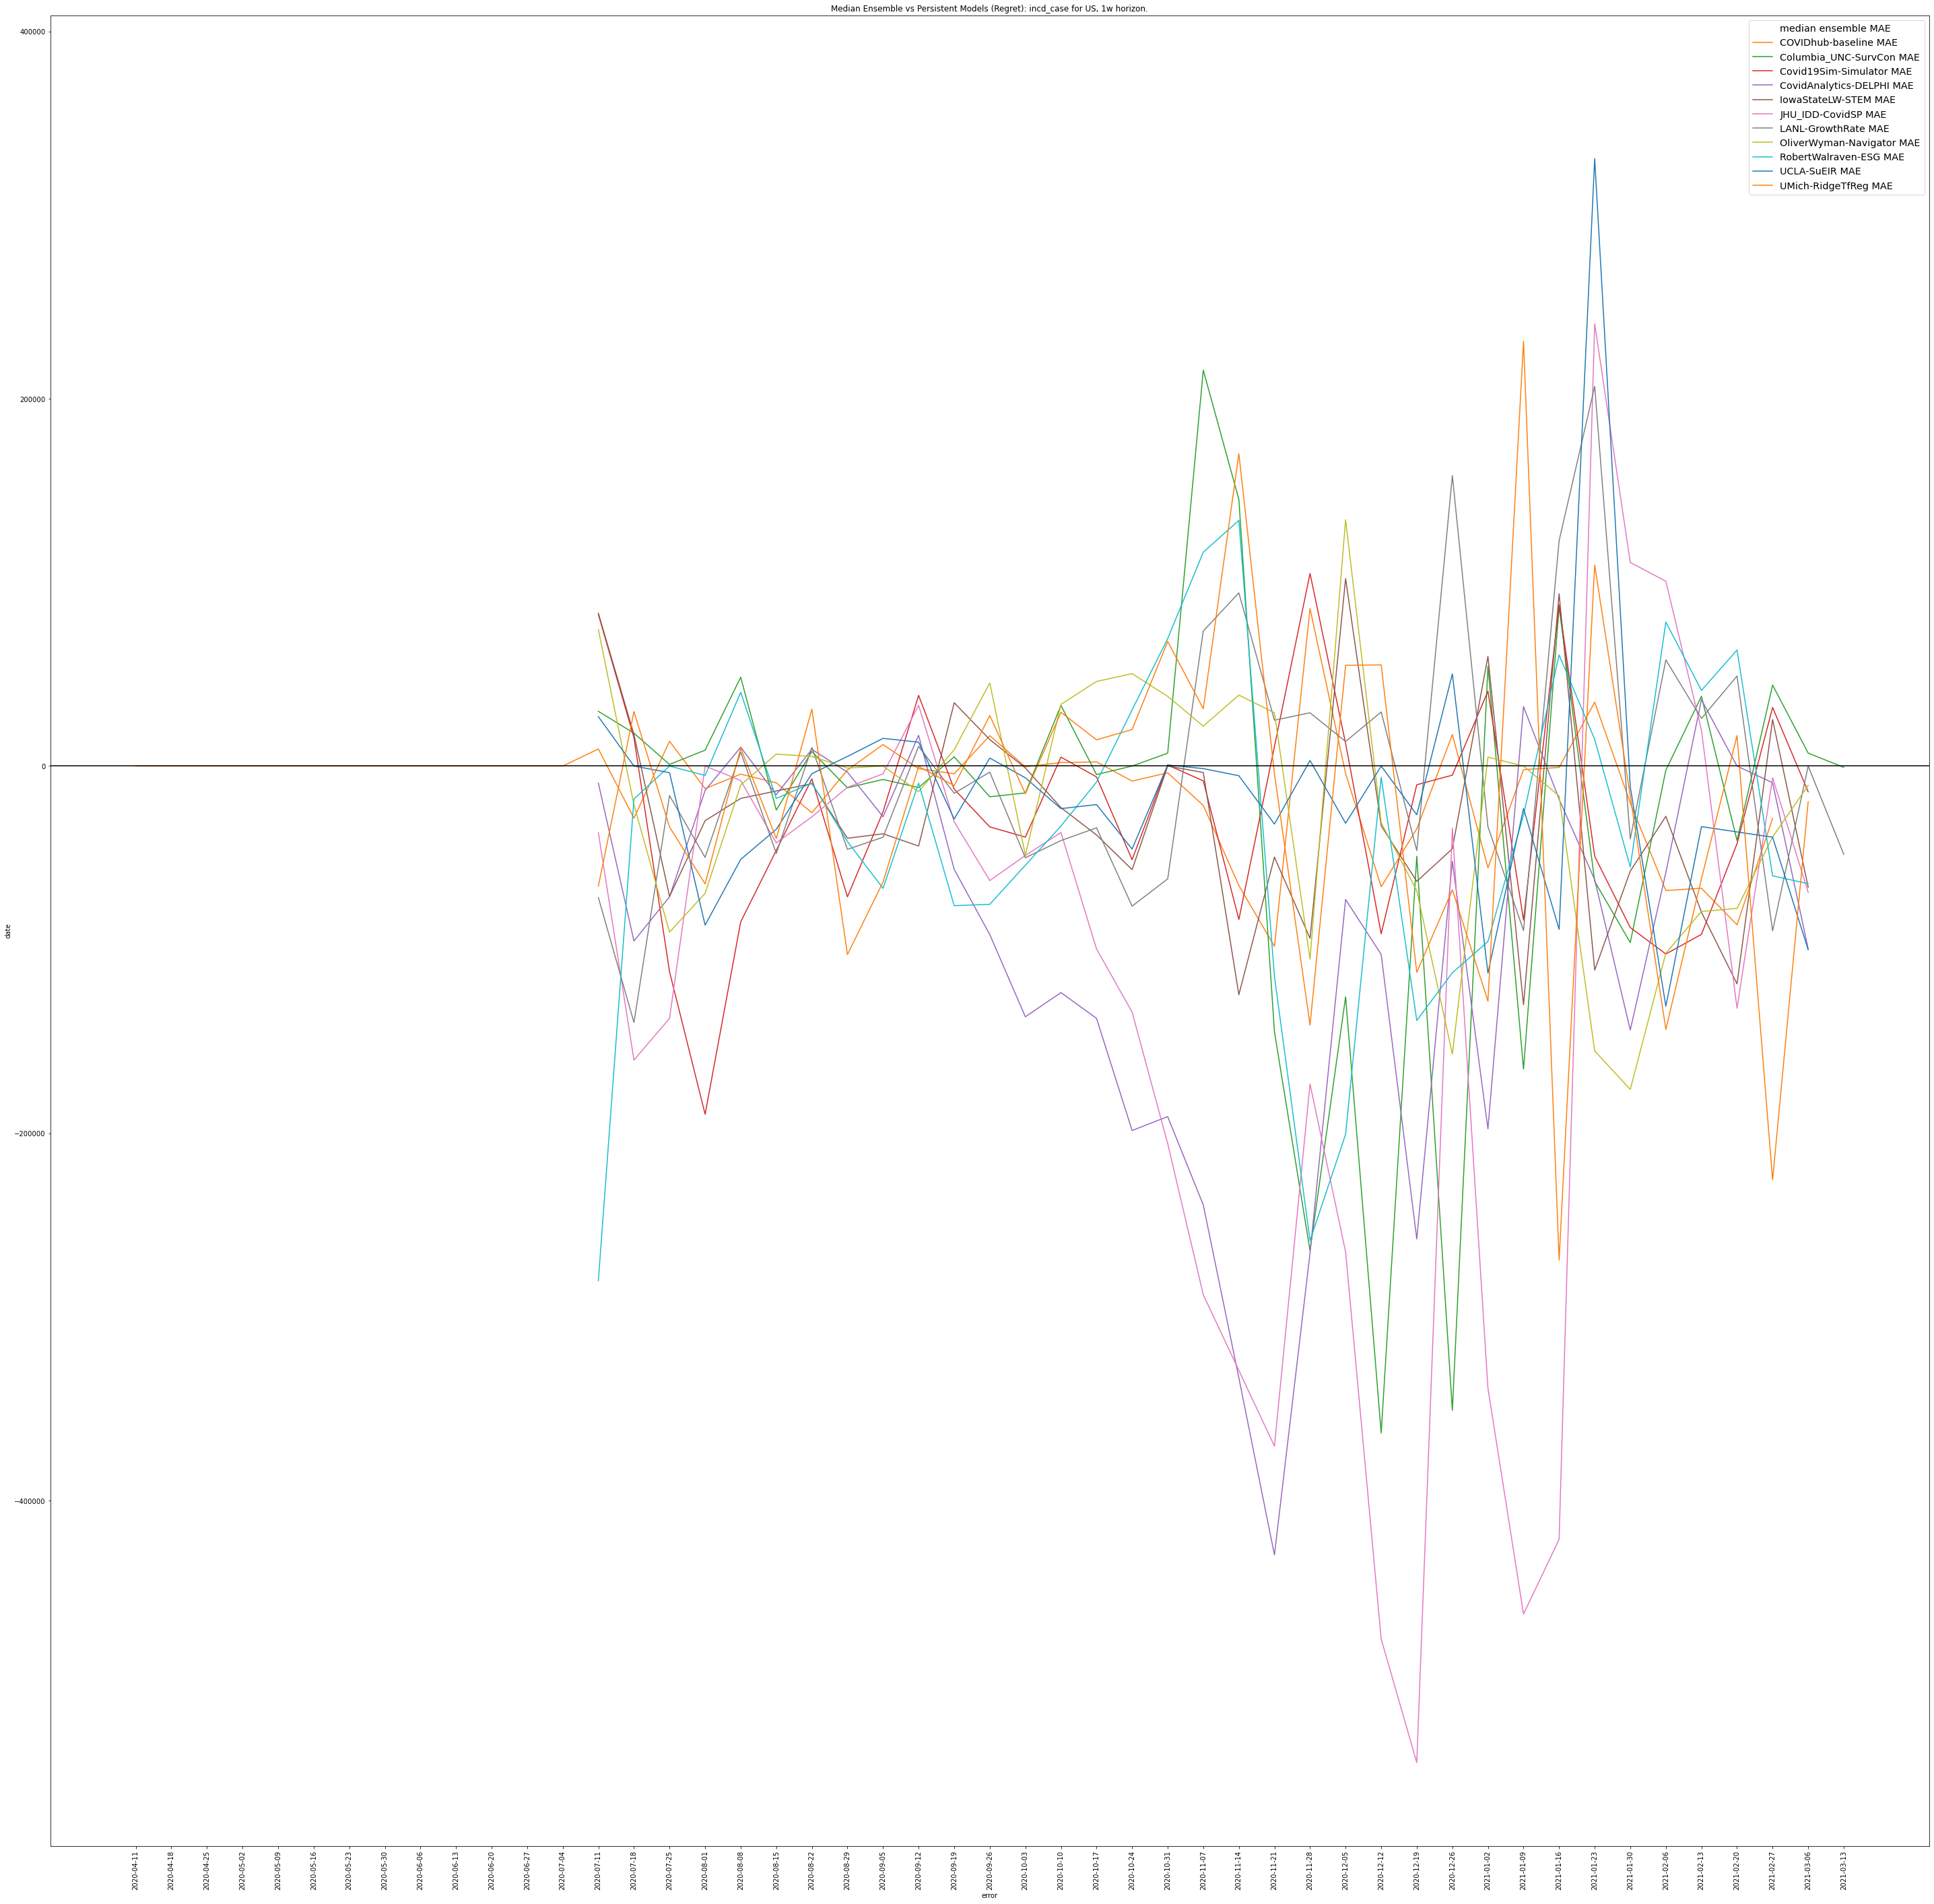

In [14]:
"""
PLOT 6: all ensembles and persistant models, regret
"""
fig, ax = plt.subplots(figsize=(50,50))
ax.plot(MEDENS_dates, MEDENS_loss.values, label='median ensemble MAE', linewidth=0)
for mod in most_dates:
        #make model series
        model_choice = str(mod)
        IND_model = model_pred_df['value'][model_choice]
        IND_data = IND_model.reset_index()
        IND_dates = IND_data['target_end_date'].tolist() 
        IND_dict = {}
        for index, row in IND_data.iterrows():
            IND_dict[row["target_end_date"]] = row["value"]
        IND_series = pd.Series(data=IND_dict, index=IND_dates)
        
        #make filtered groundtruth series
        GT_filter_dict = {}
        for index, row in GT_data.iterrows():
            dat = row["date"].date()
            datestr = dat.strftime("%Y-%m-%d")
            if datestr in IND_dates:
                GT_filter_dict[datestr] = row["gt"]
        GT_filter_series = pd.Series(data=GT_filter_dict, index=IND_dates)

        #make filtered median ensemble series
        MED_filter_dict = {}
        for index, row in MEDENS_data.iterrows():
            dat = row["target_end_date"]
            if dat in IND_dates:
                MED_filter_dict[dat] = row["value"]
        MED_filter_series = pd.Series(data=MED_filter_dict, index=IND_dates)

        #calculate MAE
        IND_loss = MAELoss.loss(0,GT_filter_series,IND_series)
        MED_filter_loss = MAELoss.loss(0,GT_filter_series,MED_filter_series)
        
        #calculate regret
        IND_MED_regret = regretFind(MED_filter_loss, IND_loss)
        ax.plot(IND_dates, IND_MED_regret.values, label=f'{model_choice} MAE')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.axhline(y=0, color='black', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('error')
plt.ylabel('date')
plt.title(f'Median Ensemble vs Persistent Models (Regret): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()

'\nPLOT 7: all ensembles and best persistent model vs groundtruth, data\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

([<matplotlib.axis.XTick at 0x7fa0ae6cf890>,
 <a list of 24 Text major ticklabel objects>)

Text(0.5, 0, 'count')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Ensembles vs COVIDhub-baseline (raw data): incd_case for US, 1w horizon.')

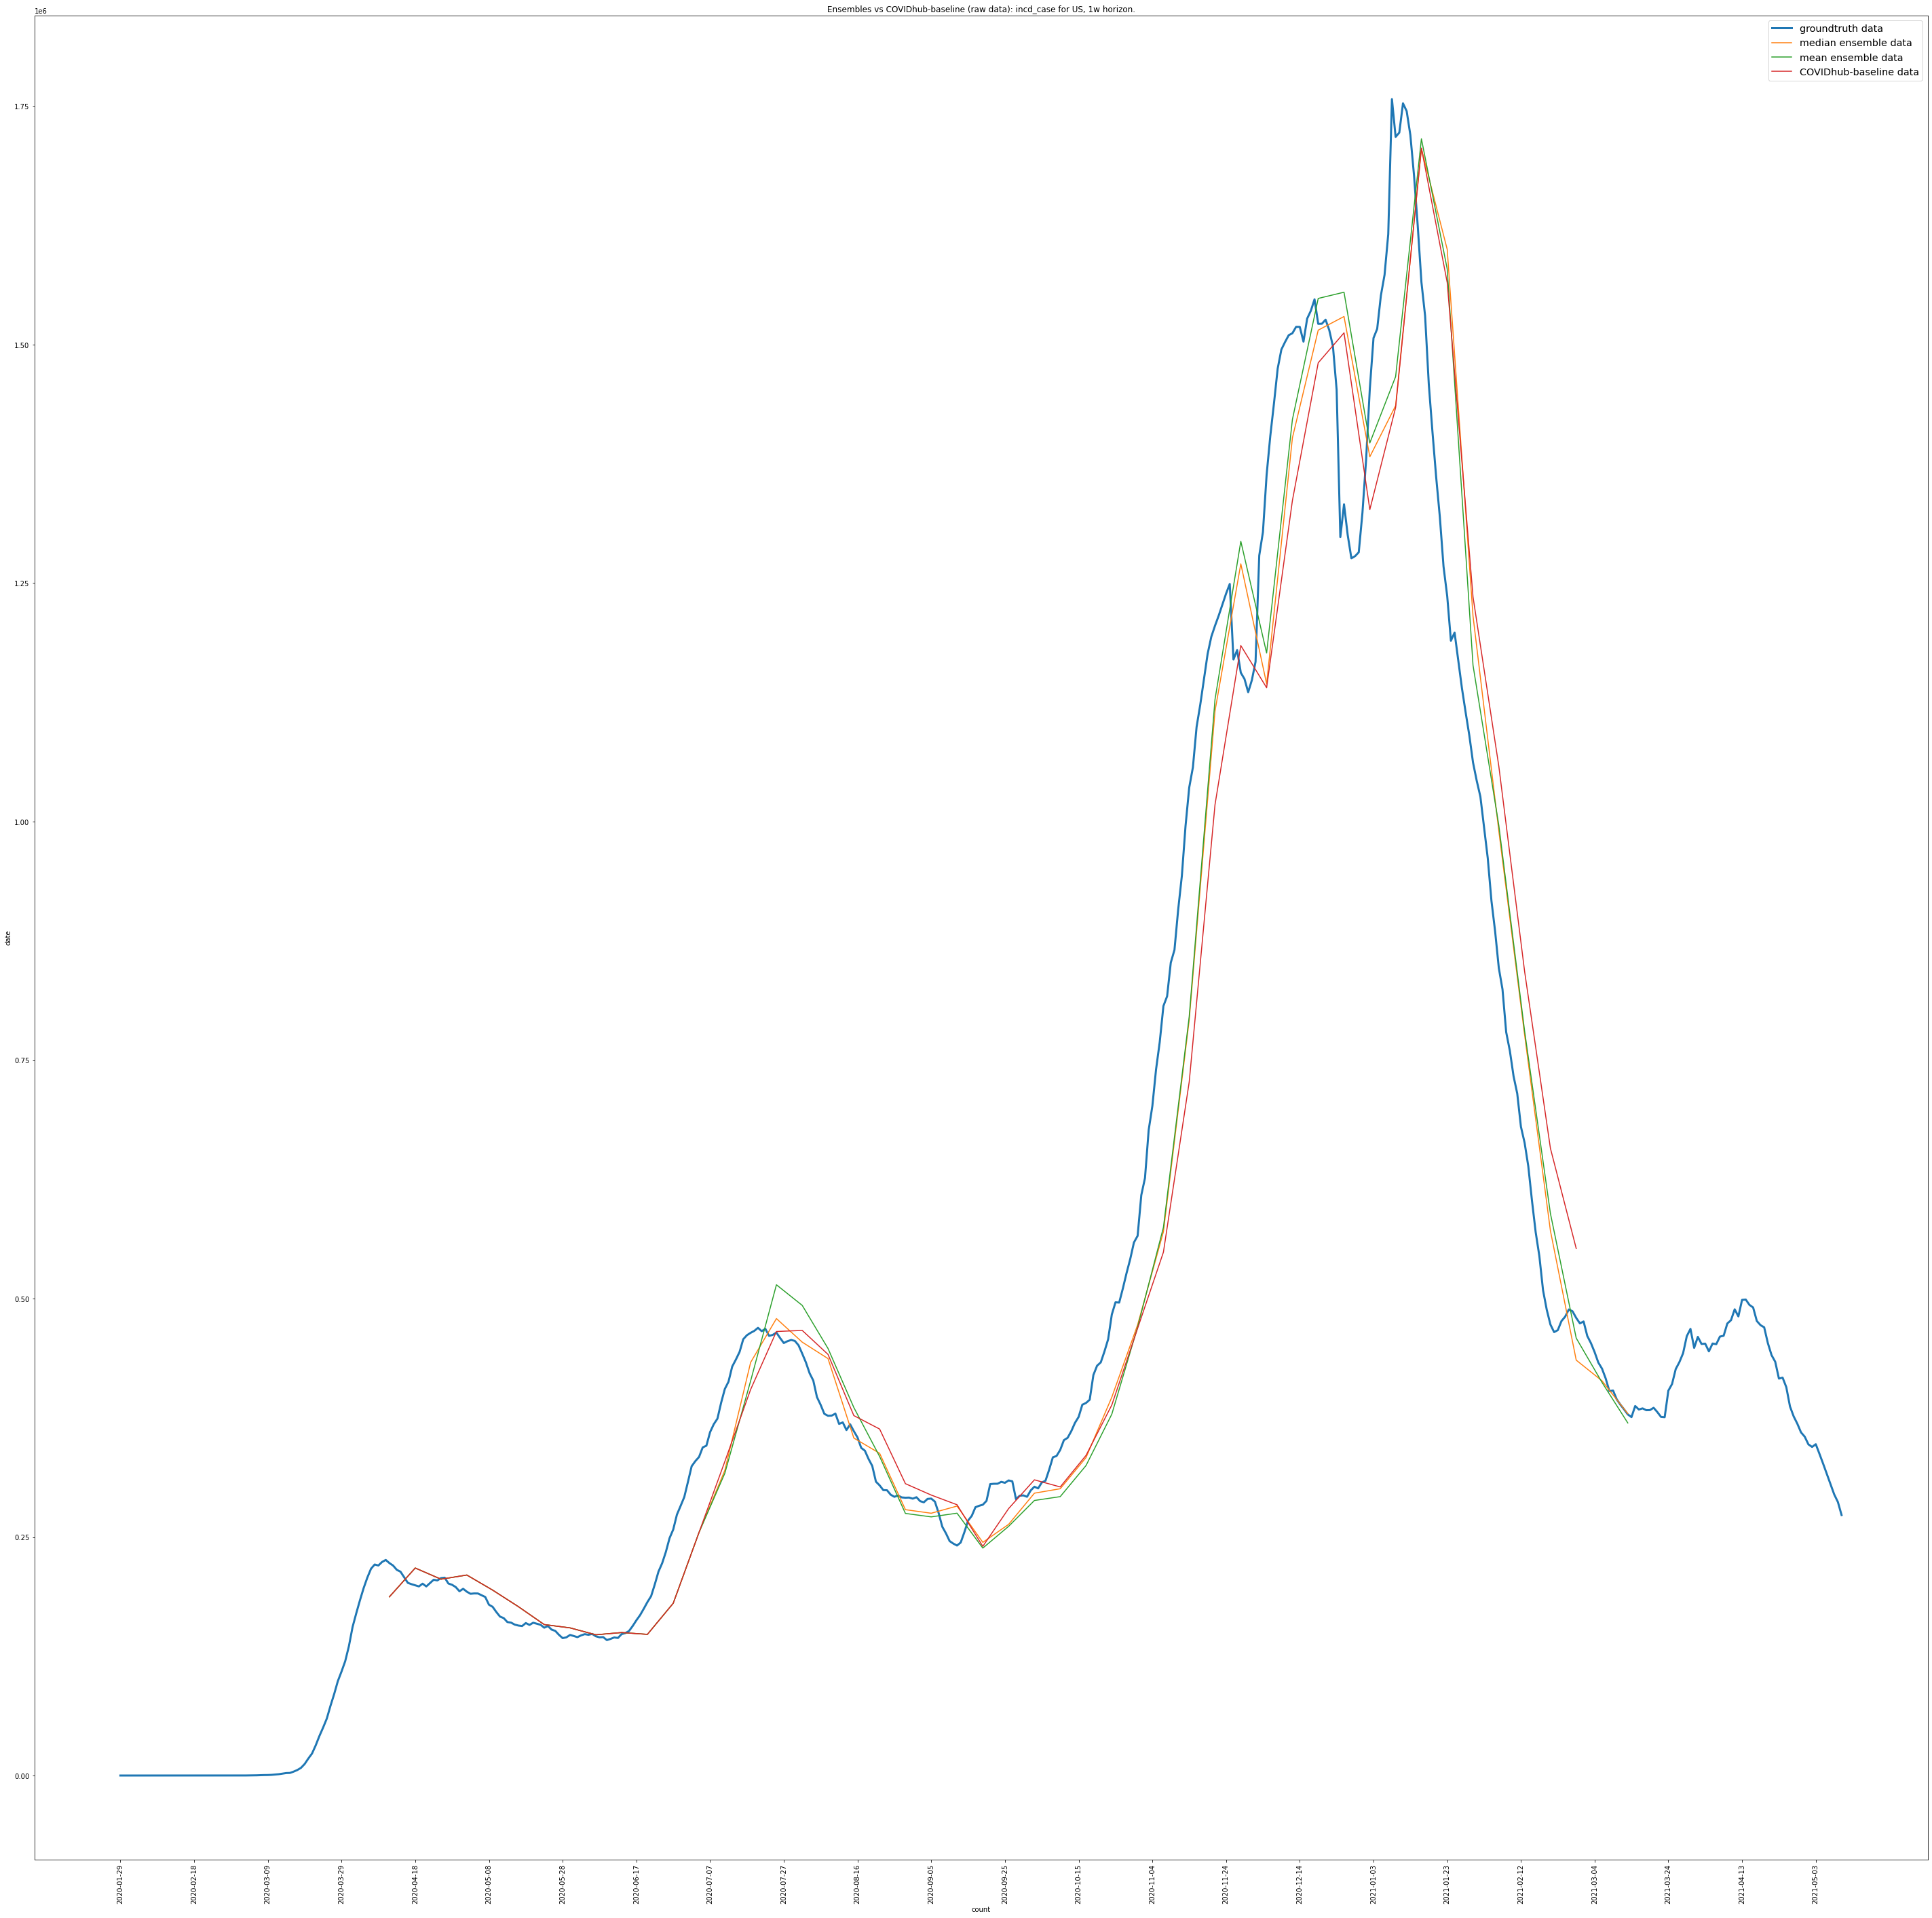

In [15]:
"""
PLOT 7: all ensembles and best persistent model vs groundtruth, data
"""
#best pers. inc_case: COVIDhub-baseline
#best pers. inc_death: UMass-MechBayes

#make model plot
BEST_model = model_pred_df['value'][best_mod]
BEST_data = BEST_model.reset_index()
BEST_dates = BEST_data['target_end_date'].tolist()
BEST_vals = BEST_data['value']

fig, ax = plt.subplots(figsize=(50,50))
ax.plot(GT_dates, GT_vals, label='groundtruth data', linewidth=3)
ax.plot(MEDENS_dates, MEDENS_vals, label='median ensemble data')
ax.plot(MEAENS_dates, MEAENS_vals, label='mean ensemble data')
ax.plot(BEST_dates, BEST_vals, label=f'{best_mod} data')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(GT_dates), 20))
plt.xlabel('count')
plt.ylabel('date')
plt.title(f'Ensembles vs {best_mod} (raw data): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()

'\nPLOT 8: all ensembles and best persistent model, MAE\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text major ticklabel objects>)

Text(0.5, 0, 'error')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Ensembles vs COVIDhub-baseline (MAE): incd_case for US, 1w horizon.')

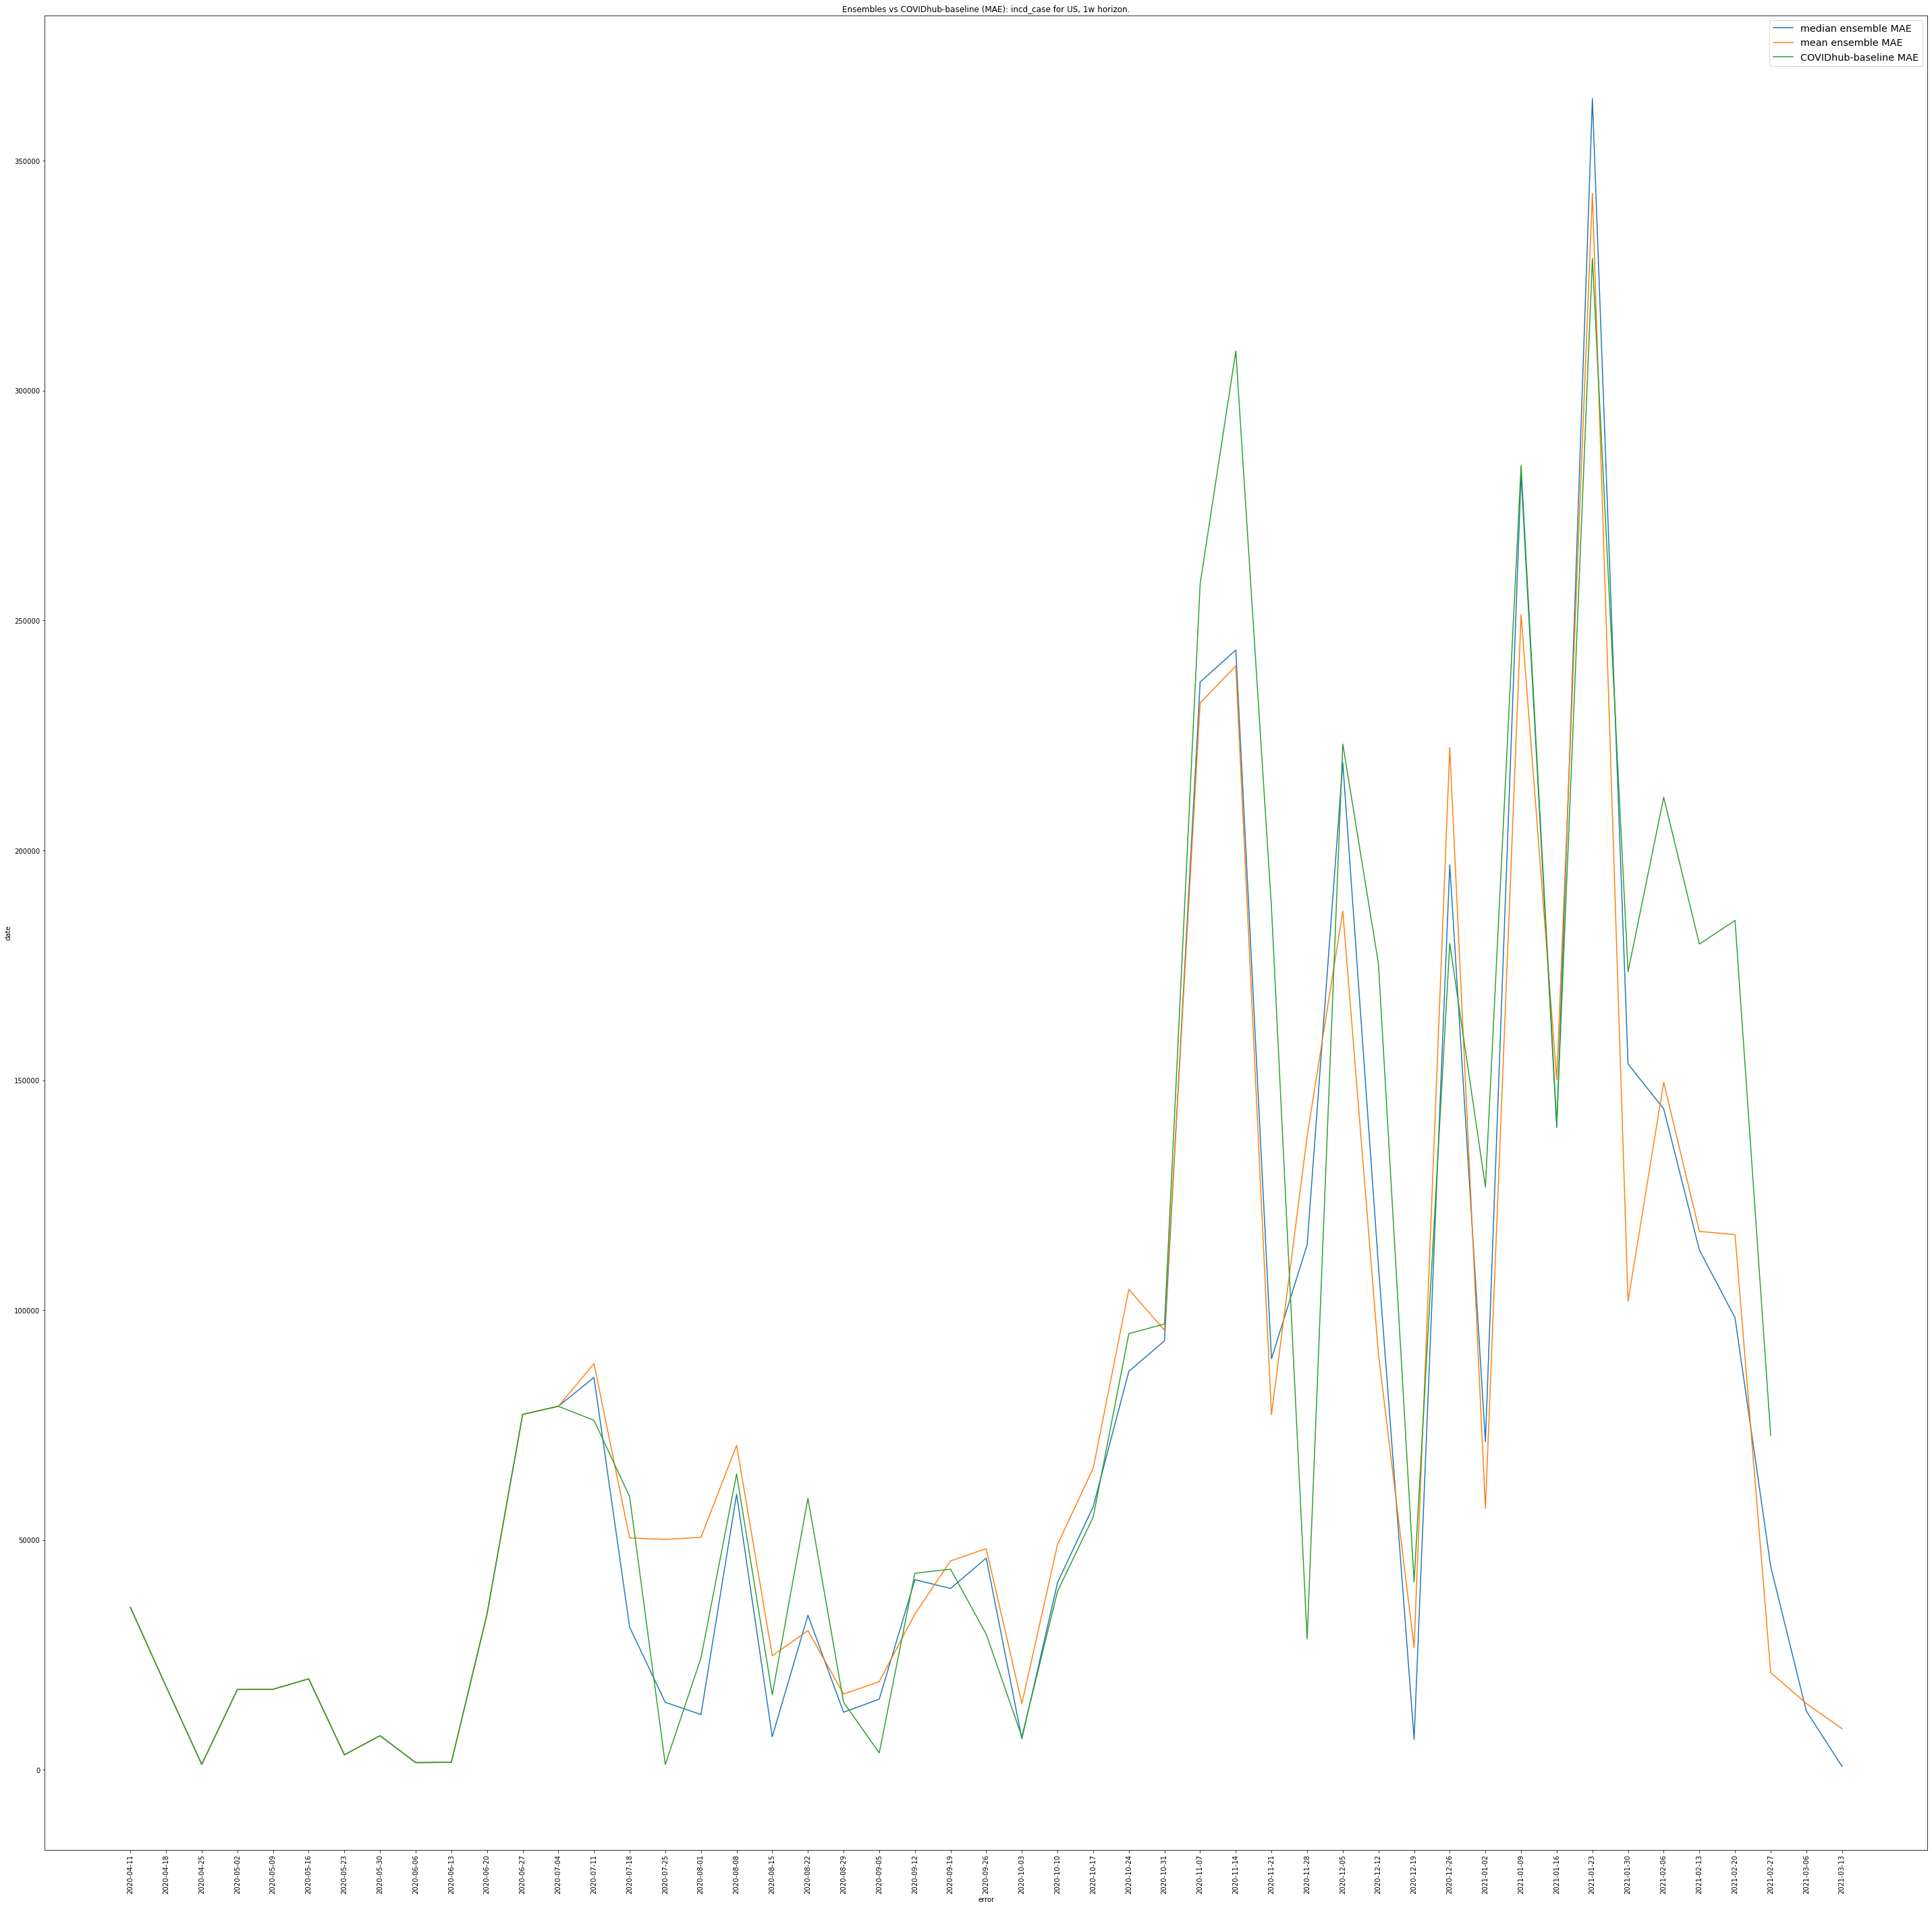

In [16]:
"""
PLOT 8: all ensembles and best persistent model, MAE
"""
#make model series
BEST_dict = {}
for index, row in BEST_data.iterrows():
    BEST_dict[row["target_end_date"]] = row["value"]
BEST_series = pd.Series(data=BEST_dict, index=BEST_dates)

#make filtered groundtruth series
GT_bfilter_dict = {}
for index, row in GT_data.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in BEST_dates:
        GT_bfilter_dict[datestr] = row["gt"]
GT_bfilter_series = pd.Series(data=GT_bfilter_dict, index=BEST_dates)

#calculate and plot model MAE
BEST_loss = MAELoss.loss(0,GT_bfilter_series,BEST_series)

fig, ax = plt.subplots(figsize=(50,50))
ax.plot(MEDENS_dates, MEDENS_loss.values, label='median ensemble MAE')
ax.plot(MEAENS_dates, MEAENS_loss.values, label='mean ensemble MAE')
ax.plot(BEST_dates, BEST_loss.values, label=f'{best_mod} MAE')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.xticks(rotation=90)
plt.xlabel('error')
plt.ylabel('date')
plt.title(f'Ensembles vs {best_mod} (MAE): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()

'\nPLOT 9: all ensembles and best persistent model, regret\n'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text major ticklabel objects>)

Text(0.5, 0, 'error')

Text(0, 0.5, 'date')

Text(0.5, 1.0, 'Median Ensemble vs COVIDhub-baseline (Regret): incd_case for US, 1w horizon.')

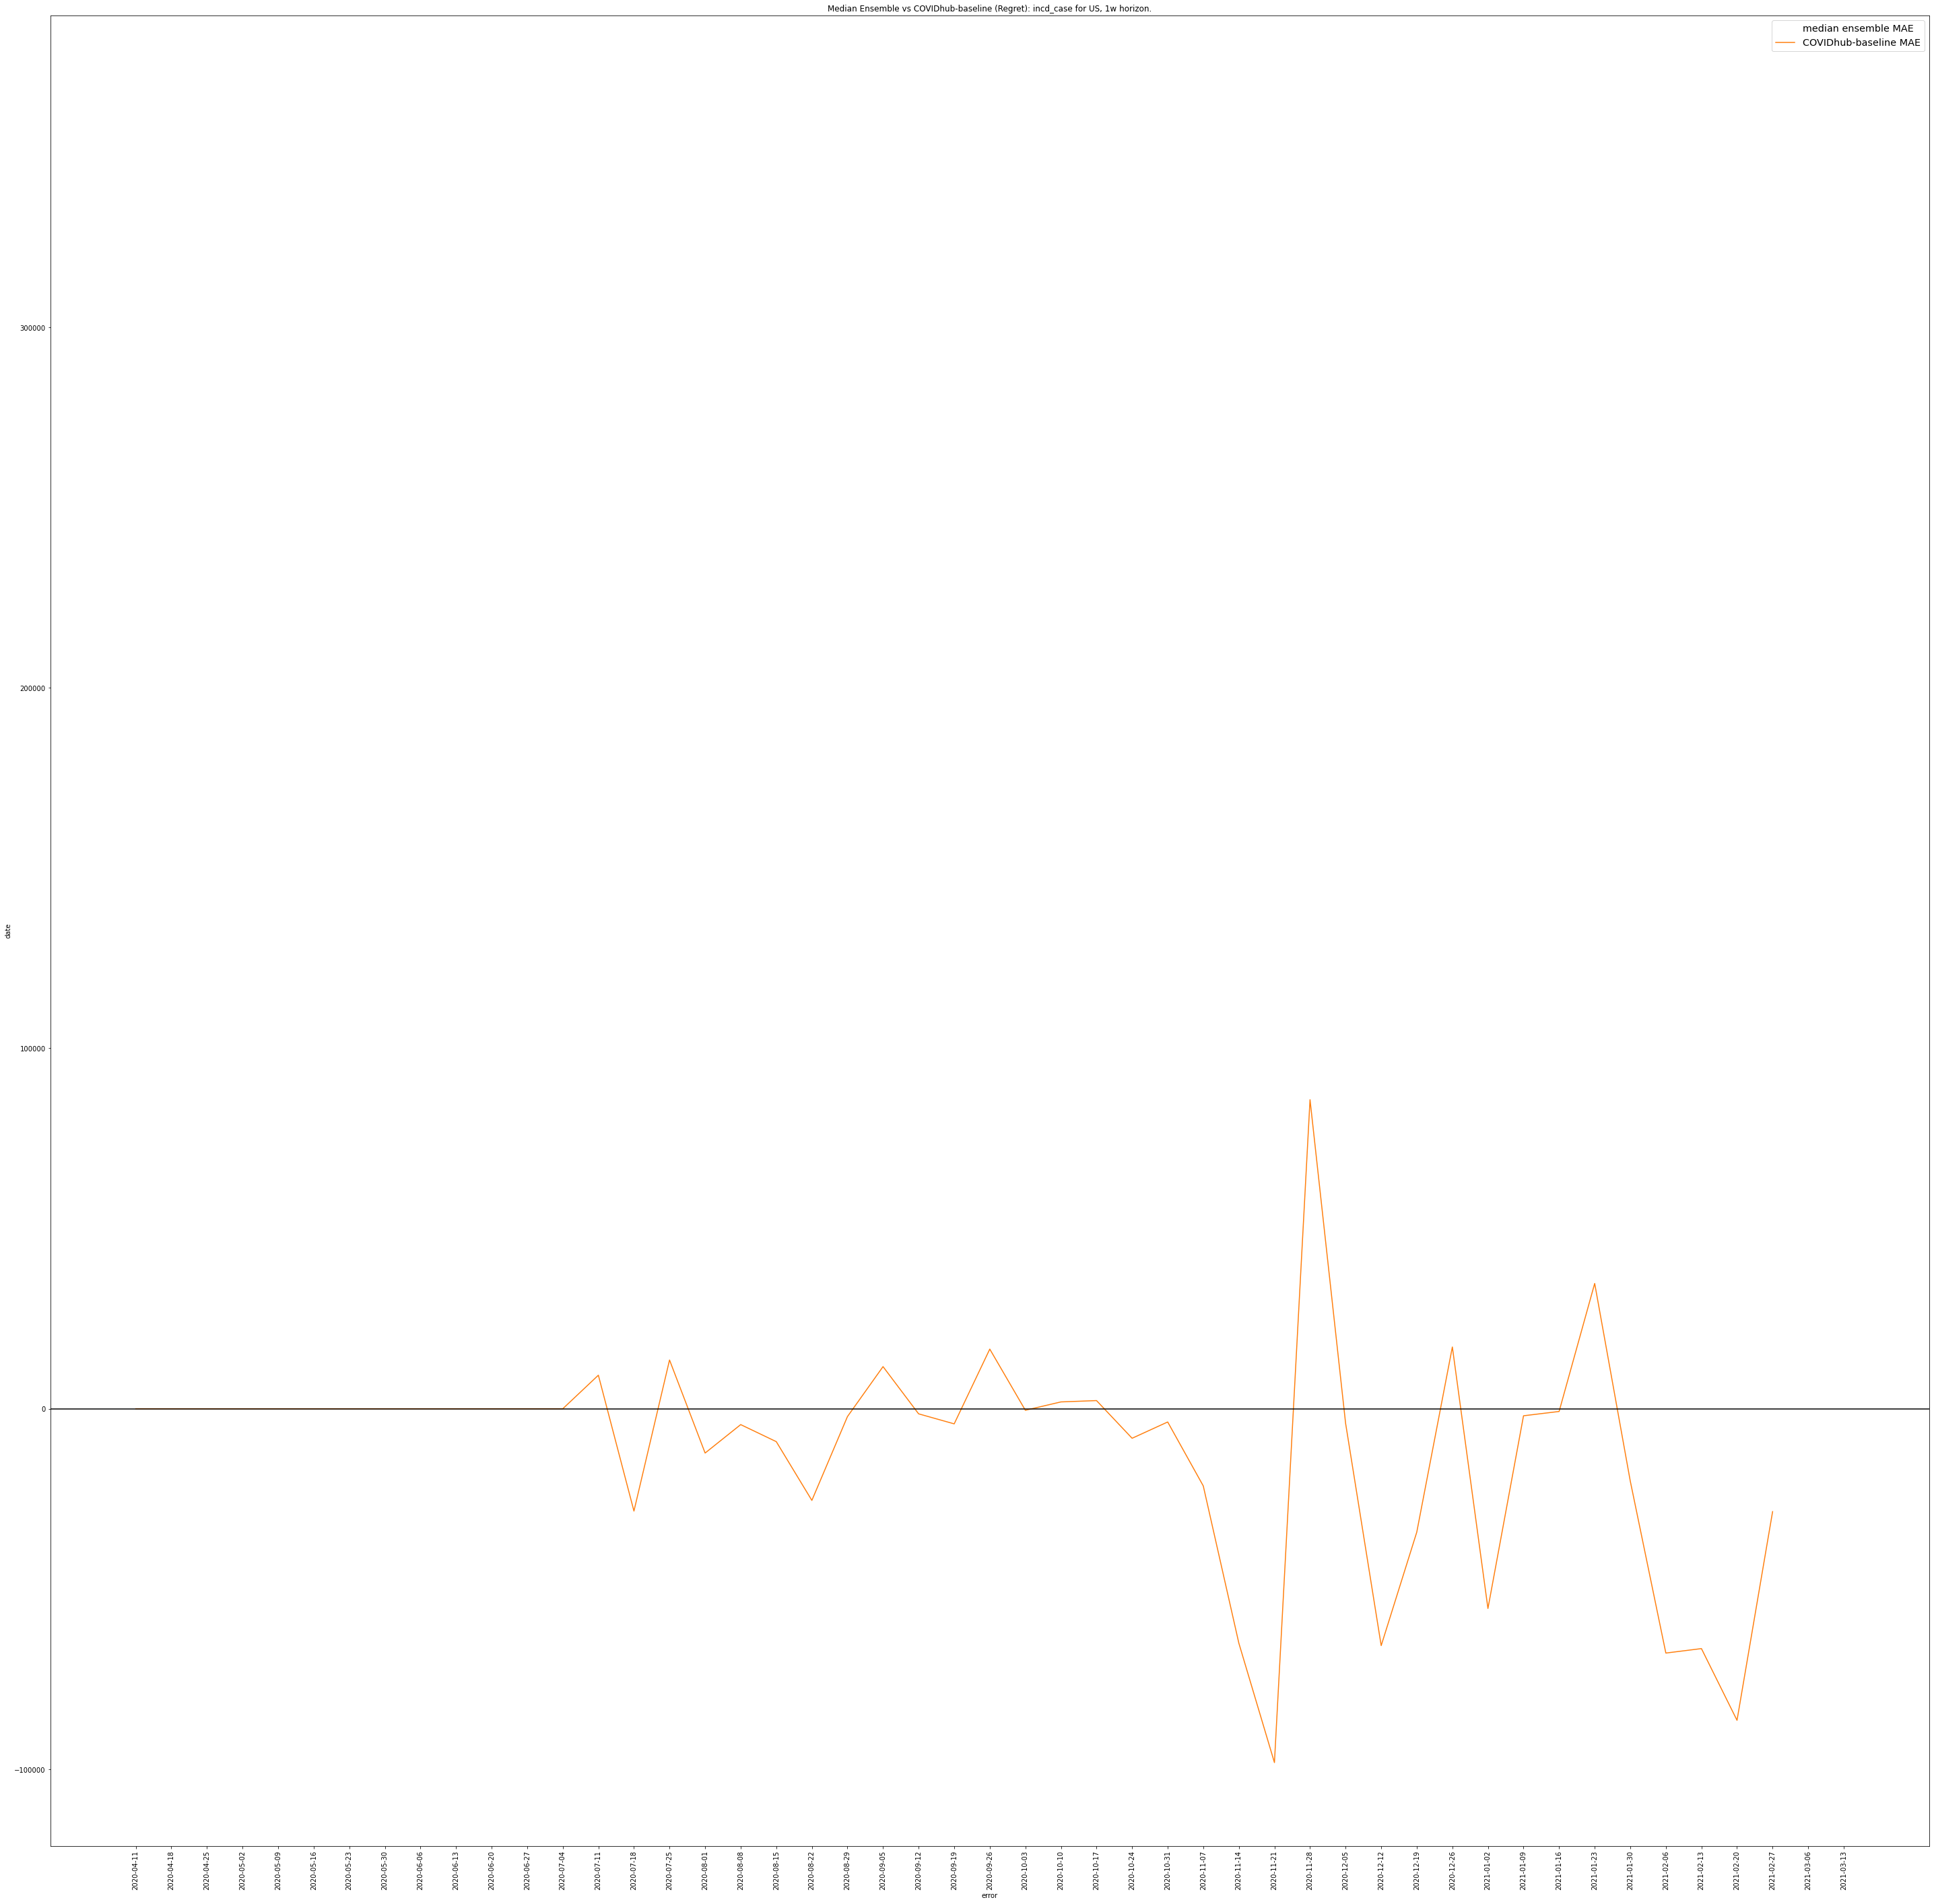

In [17]:
"""
PLOT 9: all ensembles and best persistent model, regret
"""


#make filtered median ensemble series
MED_bfilter_dict = {}
for index, row in MEDENS_data.iterrows():
    dat = row["target_end_date"]
    if dat in BEST_dates:
        MED_bfilter_dict[dat] = row["value"]
MED_bfilter_series = pd.Series(data=MED_bfilter_dict, index=BEST_dates)

#calculate MAE
MED_bfilter_loss = MAELoss.loss(0,GT_bfilter_series,MED_bfilter_series)

#calculate regret
BEST_regret = regretFind(MED_bfilter_loss, BEST_loss)


fig, ax = plt.subplots(figsize=(50,50))
ax.plot(MEDENS_dates, MEDENS_loss.values, label='median ensemble MAE', linewidth=0)
ax.plot(BEST_dates, BEST_regret.values, label=f'{best_mod} MAE')
legend = ax.legend(loc='upper right', fontsize='x-large')
plt.axhline(y=0, color='black', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('error')
plt.ylabel('date')
plt.title(f'Median Ensemble vs {best_mod} (Regret): {data_type} for {state_abb}, {horizon_type} horizon.')
plt.show()

In [29]:
"""
viewing models
"""
count_dict = {}
to_view = model_pred_df['value']
for mod in 

'\nviewing models\n'

model              location  target_end_date
COVIDhub-baseline  US        2020-04-11         187367.0
                             2020-04-18         217543.0
                             2020-04-25         205801.0
                             2020-05-02         210195.0
                             2020-05-09         194385.0
Name: value, dtype: float64